<a href="https://colab.research.google.com/github/Vittori00/BB84-Protocol/blob/main/BB84_Vittori_603188.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Librerie principali (già installate in Colab con !pip install qiskit qiskit-aer matplotlib numpy)
!pip install qiskit qiskit-aer matplotlib numpy
!pip install pylatexenc
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython.display import display
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, pauli_error
from scipy.special import comb

In [ ]:
# ==========================
# BB84 - Main Utility Functions
# ==========================
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, pauli_error
from math import comb
import numpy as np
import matplotlib.pyplot as plt

# ==========================
# BUILD BB84 CIRCUIT
# ==========================
def build_bb84(with_eve=False, draw=False):
    """
    Builds the BB84 quantum circuit.
    Uses 2 or 3 qubits depending on whether Eve (the eavesdropper) is included.
    Classical registers are used for Alice's, Bob's, and Eve's bit and basis choices.
    """
    # Quantum and classical register setup
    if with_eve:
        qr = QuantumRegister(3, 'q')
        crAb = ClassicalRegister(1, 'cAb')  # Alice's basis
        crA = ClassicalRegister(1, 'cA')    # Alice's bit
        crB = ClassicalRegister(1, 'cB')    # Bob's basis
        crM = ClassicalRegister(1, 'cM')    # Bob's measurement
        crE = ClassicalRegister(1, 'cE')    # Eve's basis
        crME = ClassicalRegister(1, 'cM_eve')  # Eve's measurement
        qc = QuantumCircuit(qr, crM, crB, crA, crAb, crE, crME)
    else:
        qr = QuantumRegister(2, 'q')
        crAb = ClassicalRegister(1, 'cAb')
        crA = ClassicalRegister(1, 'cA')
        crB = ClassicalRegister(1, 'cB')
        crM = ClassicalRegister(1, 'cM')
        qc = QuantumCircuit(qr, crM, crB, crA, crAb)

    # --- Step 1: Alice randomly chooses bit and basis ---
    # Use a Hadamard gate to ensure a 50/50 probability for bit and basis generation
    qc.h(qr[0])
    qc.measure(qr[0], crA)  # Random alice bit
    qc.reset(qr[0])
    qc.h(qr[0])
    qc.measure(qr[0], crAb)  # Random alice basis

    # Alice encodes the qubit according to her bit and basis
    with qc.if_test((crA, 1)):
        qc.x(qr[1])
    with qc.if_test((crAb, 1)):
        qc.h(qr[1])
    qc.barrier()

    # --- Step 2: Eve (if present) ---
    if with_eve:
        qc.reset(qr[0])
        qc.h(qr[0])
        qc.measure(qr[0], crE)  # Eve randomly chooses basis

        if not draw:
            qc.id(qr[1])  # Idle operation to keep circuit depth aligned (only in not draw mode)

        # Eve measures and re-prepares the qubit
        with qc.if_test((crE, 1)):
            qc.h(qr[1])
        qc.measure(qr[1], crME)

        with qc.if_test((crME, 1)):
            qc.x(qr[2])
        with qc.if_test((crE, 1)):
            qc.h(qr[2])
        qc.barrier()

        # --- Step 3: Bob chooses basis and measures ---
        qc.reset(qr[0])
        qc.h(qr[0])
        qc.measure(qr[0], crB)
        if not draw:
            qc.id(qr[2])
        with qc.if_test((crB, 1)):
            qc.h(qr[2])
        qc.measure(qr[2], crM)

    else:
        # --- Step 3: Bob chooses basis and measures (no Eve) ---
        qc.reset(qr[0])
        qc.h(qr[0])
        qc.measure(qr[0], crB)
        if not draw:
            qc.id(qr[1])
        with qc.if_test((crB, 1)):
            qc.h(qr[1])
        qc.measure(qr[1], crM)

    return qc


# ==========================
# SIMULATE BB84
# ==========================
def simulate(qc, noise_type=None, p=0.01, shots=300, with_eve=False):
    """
    Simulates the execution of the BB84 protocol circuit (with or without Eve)
    under various types of noise.
    Returns: (L, R_mis, P_keep)
    """
    # --- Build noise model ---
    bitflip_q1 = pauli_error([('X', p), ('I', 1 - p)])
    phaseflip_q1 = pauli_error([('Z', p), ('I', 1 - p)])
    bitphaseflip_q1 = pauli_error([('Y', p), ('I', 1 - p)])
    noise_model = NoiseModel()

    # Assign noise models based on the specified type. Noise does not affect q0 because it doesn't travel through a channel
    if noise_type == 'bitflip':
        noise_model.add_quantum_error(bitflip_q1, ['id'], [1])
        if with_eve:
            noise_model.add_quantum_error(bitflip_q1, ['id'], [2])
    elif noise_type == 'phaseflip':
        noise_model.add_quantum_error(phaseflip_q1, ['id'], [1])
        if with_eve:
            noise_model.add_quantum_error(phaseflip_q1, ['id'], [2])
    elif noise_type == 'bitphaseflip':
        noise_model.add_quantum_error(bitphaseflip_q1, ['id'], [1])
        if with_eve:
            noise_model.add_quantum_error(bitphaseflip_q1, ['id'], [2])

    # --- Execute simulation ---
    backend = AerSimulator(noise_model=noise_model)
    circ = transpile(qc, backend, optimization_level=0)
    job = backend.run(circ, shots=shots, memory=True)
    mem = job.result().get_memory()

    # --- Process classical register data ---
    cA, cAb, cB, cM = [], [], [], []
    for shot in mem:
        bits = list(map(int, shot.replace(' ', '')[::-1]))
        # Order consistent with classical register declaration
        if len(bits) >= 4:
            m, b, a, ab = bits[:4]
            cM.append(m)
            cB.append(b)
            cA.append(a)
            cAb.append(ab)

    cA, cAb, cB, cM = map(np.array, (cA, cAb, cB, cM))

    # --- Sifting step: Bob keeps bits where bases match ---
    keep_mask = (cAb == cB)
    alice_key = cA[keep_mask]
    bob_key = cM[keep_mask]

    # Compute key length, pkeep and mismatch ratio
    L = len(alice_key)
    R_mis = np.mean(alice_key != bob_key) if L > 0 else 0
    P_keep = np.mean(keep_mask)  # Around 50% expected, regardeless of the error, it's based on the bases choice
    return L, R_mis, P_keep


# ==========================
# SIMULATE MULTIPLE RUNS
# ==========================
def simulate_multiple_times(qc, noise_type=None, p=0, n_repeats=10, n_shots=300, with_eve=False):
    """
    Repeats the simulation n_repeats times to compute mean values and 95% confidence intervals.
    Returns: L_mean, mismatch_mean (%), keep_mean (%), mismatch_ci, keep_ci
    """
    mismatch_ratios, keep_ratios, Ls = [], [], []

    for _ in range(n_repeats):
        L_val, R_mis, P_keep = simulate(qc, noise_type=noise_type, p=p, shots=n_shots, with_eve=with_eve)
        mismatch_ratios.append(R_mis * 100 if R_mis is not None else 0.0)
        keep_ratios.append(P_keep * 100)
        Ls.append(L_val)

    # Mean and standard deviation
    mismatch_mean = np.mean(mismatch_ratios)
    keep_mean = np.mean(keep_ratios)
    L_mean = np.mean(Ls)
    mismatch_std = np.std(mismatch_ratios, ddof=0)
    keep_std = np.std(keep_ratios, ddof=0)

    # 95% confidence intervals (normal approximation)
    mismatch_ci = 1.96 * mismatch_std / np.sqrt(max(1, n_repeats))
    keep_ci = 1.96 * keep_std / np.sqrt(max(1, n_repeats))

    return L_mean, mismatch_mean, keep_mean, mismatch_ci, keep_ci
# ==========================
# PLOT: Mismatch & Keep Curves
# ==========================
def plot_mismatch_keep_curve(qc, noise_type, p_values, n_repeats=30, n_shots=300, with_eve=False):
    """
    Plots two curves (and export versions) showing:
      - The Mismatch Ratio (differences between Alice's and Bob's keys)
      - The Keep Ratio (percentage of bits retained)
    as a function of the error probability p.
    """
    mismatch_means, keep_means = [], []
    mismatch_cis, keep_cis = [], []

    # --- Simulate for each p value ---
    for p in p_values:
        L, mismatch_mean, keep_mean, mismatch_ci, keep_ci = simulate_multiple_times(
            qc, noise_type=noise_type, p=p, n_repeats=n_repeats,
            n_shots=n_shots, with_eve=with_eve
        )
        mismatch_means.append(mismatch_mean)
        keep_means.append(keep_mean)
        mismatch_cis.append(mismatch_ci)
        keep_cis.append(keep_ci)

    # --- Main Plot ---
    plt.style.use("seaborn-v0_8-darkgrid")
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot Mismatch and Keep curves with error bars
    ax.errorbar(p_values, mismatch_means, yerr=mismatch_cis, fmt='o-', capsize=4,
                label="Mismatch Ratio", color='#D90429', linewidth=2, markersize=6)
    ax.errorbar(p_values, keep_means, yerr=keep_cis, fmt='s--', capsize=4,
                label="Keep Ratio", color='#2B2D42', linewidth=2, markersize=6)

    # Axis labels and title
    ax.set_xlabel('Error Probability p', fontsize=13)
    ax.set_ylabel('Percentage (%)', fontsize=13)
    ax.set_title(f'BB84 – Effect of {noise_type} Errors', fontsize=15, fontweight='bold')

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 100)
    ax.legend(frameon=True, fontsize=11)
    plt.tight_layout()
    plt.show()

    # --- Transparent export version ---
    fig, ax = plt.subplots(figsize=(10, 6), facecolor='none')
    ax.set_facecolor('none')

    ax.errorbar(p_values, mismatch_means, yerr=mismatch_cis, fmt='-o', color='#EF233C',
                ecolor='#EF233C', label='Mismatch Ratio', capsize=5)
    ax.errorbar(p_values, keep_means, yerr=keep_cis, fmt='--s', color='#8D99AE',
                ecolor='#8D99AE', label='Keep Ratio', capsize=5)

    ax.set_xlabel('Error Probability p', fontsize=13, color='black')
    ax.set_ylabel('Percentage (%)', fontsize=13, color='black')
    ax.set_title(f'Mismatch & Keep Ratio – {noise_type} (BB84)', fontsize=14, color='black')
    ax.grid(True, linestyle=':', color='gray', alpha=0.5)
    ax.legend(facecolor='none', edgecolor='black', fontsize=11)

    plt.tight_layout()
    try:
        plt.savefig(f"images/bb84_mismatch_keep_{noise_type}.png", transparent=True, dpi=300)
    except Exception:
        pass
    plt.close(fig)


# ==========================
# EVE UNDETECTED PROBABILITY
# ==========================
def p_undetected(L, R_mis, k):
    """
    Computes the probability that Eve remains undetected
    when a fraction k of the key (length L) is verified.
    R_mis is the fraction of mismatches among sifted bits (not in percentage).
    """
    L = int(round(L))
    M = int(round(R_mis * L)) if L else 0 #missed bit in percentage
    s = int(round(k * L)) if L else 0 #sample size
    if s == 0 or M == 0:
        return 1.0
    if s > L or M > L or L - M < s:
        return 0.0
    return comb(L - M, s, exact=True) / comb(L, s, exact=True) #Probability of “picking s good bits” from a key of L bits that contains M errors.
                                                               #If at least one checked bit is wrong, Eve is detected; otherwise, she remains undetected.


# ==========================
# PLOT: Undetection Probability vs k
# ==========================
def plot_p_undetected_vs_k(L, R_mis, k_values, noise_type=None):
    """
    Plots the probability that Eve remains undetected as a function
    of the fraction k of the key being checked.
    """
    p_undetected_values = [p_undetected(L, R_mis, k) for k in k_values]
    x_vals = np.array(k_values) * 100

    plt.style.use("seaborn-v0_8-whitegrid")
    fig, ax = plt.subplots(figsize=(9, 5))

    # Plot and fill area under curve
    ax.plot(x_vals, p_undetected_values, 'o-', color='#008080', linewidth=2, markersize=6)
    ax.fill_between(x_vals, p_undetected_values, alpha=0.2, color='#00CED1')

    ax.set_xlabel('k (%) of checked bits', fontsize=13)
    ax.set_ylabel('P(Eve undetected)', fontsize=13)
    ax.set_title(f'Eavesdropper Undetection Probability (BB84, error={noise_type})',
                 fontsize=14, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

    # --- Transparent export version ---
    fig, ax = plt.subplots(figsize=(9, 5), facecolor='none')
    ax.set_facecolor('none')
    ax.plot(x_vals, p_undetected_values, 'o-', color='#FF7F50', linewidth=2, label='P(undetected)')
    ax.set_xlabel('k (%) of checked bits', fontsize=13, color='black')
    ax.set_ylabel('P(Eve undetected)', fontsize=13, color='black')
    ax.set_title(f'Eve Undetection Probability – {noise_type} (BB84)', fontsize=14, color='black')
    ax.grid(True, linestyle=':', color='gray', alpha=0.6)
    ax.legend(facecolor='none', edgecolor='black', fontsize=11)
    plt.tight_layout()
    try:
        plt.savefig(f"images/bb84_p_undetected_{noise_type}.png", transparent=True, dpi=300)
    except Exception:
        pass
    plt.close(fig)


# ==========================
# MULTI-LAYOUT PLOT: Mismatch & Keep across different L
# ==========================
def plot_all_mismatch_keep_curves(qc, noise_type, p_values, n_repeats, with_eve=False):
    """
    Displays Mismatch and Keep Ratios for different initial key lengths (L_init).
    Each subplot shows how protocol performance degrades as error probability increases.
    """
    L_values = [50, 100, 300, 700, 1000, 1500]
    fig, axes = plt.subplots(2, 3, figsize=(22, 12))
    axes = axes.flatten()
    plt.style.use("seaborn-v0_8-dark-palette")

    # --- Compute and plot per L_init ---
    for idx, L in enumerate(L_values):
        mismatches, keeps, mismatch_cis, keep_cis = [], [], [], []

        for p in p_values:
            L_mean, mm, km, mm_ci, km_ci = simulate_multiple_times(
                qc, noise_type=noise_type, p=p, n_repeats=n_repeats,
                n_shots=L, with_eve=with_eve
            )
            mismatches.append(mm)
            keeps.append(km)
            mismatch_cis.append(mm_ci)
            keep_cis.append(km_ci)

        ax = axes[idx]
        ax.errorbar(p_values, mismatches, yerr=mismatch_cis, fmt='-o',
                    color='#C1121F', ecolor='#C1121F', capsize=3,
                    label='Mismatch Ratio')
        ax.errorbar(p_values, keeps, yerr=keep_cis, fmt='--s',
                    color='#003049', ecolor='#003049', capsize=3,
                    label='Keep Ratio')

        ax.set_title(f'$L_{{init}}$ = {L}', fontsize=13, fontweight='bold')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 100)
        ax.set_xlabel('Error Probability p', fontsize=11)
        ax.set_ylabel('Percentage (%)', fontsize=11)
        ax.grid(True, linestyle=':', color='gray', alpha=0.6)
        ax.legend(fontsize=10)

    fig.suptitle(f'BB84 – Mismatch & Keep Ratios under {noise_type} Errors', fontsize=18, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # --- Transparent export version ---
    fig, axes = plt.subplots(2, 3, figsize=(22, 12), facecolor='none')
    axes = axes.flatten()
    for ax in axes:
        ax.set_facecolor('none')

    for idx, L in enumerate(L_values):
        mismatches, keeps, mismatch_cis, keep_cis = [], [], [], []
        for p in p_values:
            L_mean, mm, km, mm_ci, km_ci = simulate_multiple_times(
                qc, noise_type=noise_type, p=p, n_repeats=n_repeats,
                n_shots=L, with_eve=with_eve
            )
            mismatches.append(mm)
            keeps.append(km)
            mismatch_cis.append(mm_ci)
            keep_cis.append(km_ci)

        ax = axes[idx]
        ax.errorbar(p_values, mismatches, yerr=mismatch_cis, fmt='-o',
                    color='#D62828', ecolor='#D62828', capsize=3, label='Mismatch')
        ax.errorbar(p_values, keeps, yerr=keep_cis, fmt='--s',
                    color='#457B9D', ecolor='#457B9D', capsize=3, label='Keep')
        ax.set_title(f'L_init = {L}', fontsize=13, color='black')
        ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.4)
        ax.legend(fontsize=10, facecolor='none', edgecolor='black')

    fig.suptitle(f'Mismatch & Keep Ratios ({noise_type} – BB84)', fontsize=18, color='black')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    try:
        plt.savefig(f"images/bb84_all_mismatch_keep_{noise_type}.png", transparent=True, dpi=300)
    except Exception:
        pass
    plt.close(fig)


# ==========================
# MULTI-LAYOUT PLOT: Eve Undetection Probability
# ==========================
def p_undetected_mod(L, R_mis, k):
    """ Wrapper around p_undetected() for modularity. """
    return p_undetected(L, R_mis, k)


def plot_all_p_undetected_curves(qc, noise_type, p, n_repeats, with_eve=False):
    """
    Displays, in a grid layout, how the probability of Eve remaining undetected
    varies with the fraction k of checked bits, for different key lengths (L_init).
    """
    L_values = [50, 100, 300, 700, 1000, 1500]
    fig, axes = plt.subplots(2, 3, figsize=(22, 12))
    axes = axes.flatten()
    plt.style.use("seaborn-v0_8-whitegrid")

    # --- Main plots for each L_init ---
    for idx, L in enumerate(L_values):
        if L == 50:
            k_values = np.arange(0, 51, 3) / 100
        elif L == 100:
            k_values = np.arange(0, 31, 2) / 100
        else:
            k_values = np.arange(0, 21, 1) / 100

        # Compute mean mismatch for this L_init
        L_mean, R_mis_percent, _, _, _ = simulate_multiple_times(
            qc, noise_type=noise_type, p=p, n_repeats=n_repeats,
            n_shots=L, with_eve=with_eve
        )
        R_mis = R_mis_percent / 100.0
        p_undetected_values = [p_undetected(L_mean, R_mis, k) for k in k_values]

        ax = axes[idx]
        ax.plot(k_values * 100, p_undetected_values, '-o',
                color='#118AB2', linewidth=2, markersize=6, label='P(undetected)')
        ax.fill_between(k_values * 100, p_undetected_values, alpha=0.15, color='#06D6A0')
        ax.set_title(f'L_init = {L}', fontsize=13, fontweight='bold')
        ax.set_xlim(0, max(k_values) * 100)
        ax.set_ylim(0, 1.05)
        ax.set_xlabel('k (%) of checked bits', fontsize=11)
        ax.set_ylabel('P(Eve undetected)', fontsize=11)
        ax.grid(True, linestyle=':', color='gray', alpha=0.5)
        ax.legend(fontsize=10)

    fig.suptitle(f'BB84 – P_undetected vs k ({noise_type} errors)', fontsize=18, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # --- Transparent export version ---
    fig, axes = plt.subplots(2, 3, figsize=(22, 12), facecolor='none')
    axes = axes.flatten()
    for ax in axes:
        ax.set_facecolor('none')

    for idx, L in enumerate(L_values):
        if L == 50:
            k_values = np.arange(0, 51, 3) / 100
        elif L == 100:
            k_values = np.arange(0, 31, 2) / 100
        else:
            k_values = np.arange(0, 21, 1) / 100

        L_mean, R_mis_percent, _, _, _ = simulate_multiple_times(
            qc, noise_type=noise_type, p=p, n_repeats=n_repeats,
            n_shots=L, with_eve=with_eve
        )
        R_mis = R_mis_percent / 100.0
        p_undetected_values = [p_undetected(L_mean, R_mis, k) for k in k_values]

        ax = axes[idx]
        ax.plot(k_values * 100, p_undetected_values, '-o',
                color='#FFD166', linewidth=2, label='P(undetected)')
        ax.set_title(f'L_init = {L}', fontsize=13, color='black')
        ax.grid(True, linestyle='--', color='gray', alpha=0.4)
        ax.legend(fontsize=10, facecolor='none', edgecolor='black')

    fig.suptitle(f'Probability Eve Remains Undetected – {noise_type} (BB84)', fontsize=18, color='black')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    try:
        plt.savefig(f"images/bb84_all_p_undetected_{noise_type}.png", transparent=True, dpi=300)
    except Exception:
        pass
    plt.close(fig)


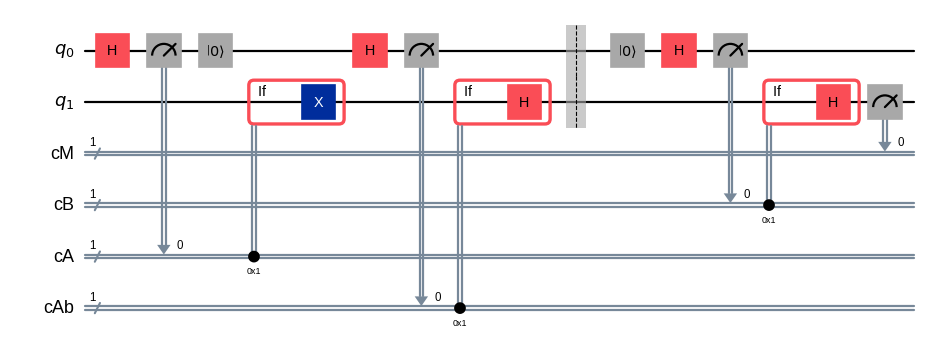

In [ ]:
qc = build_bb84(with_eve=False, draw=True)
display(qc.draw('mpl', idle_wires=False, scale=0.8))

In [ ]:
qc = build_bb84(with_eve=False)
p_values = np.arange(0, 1.05, 0.05)

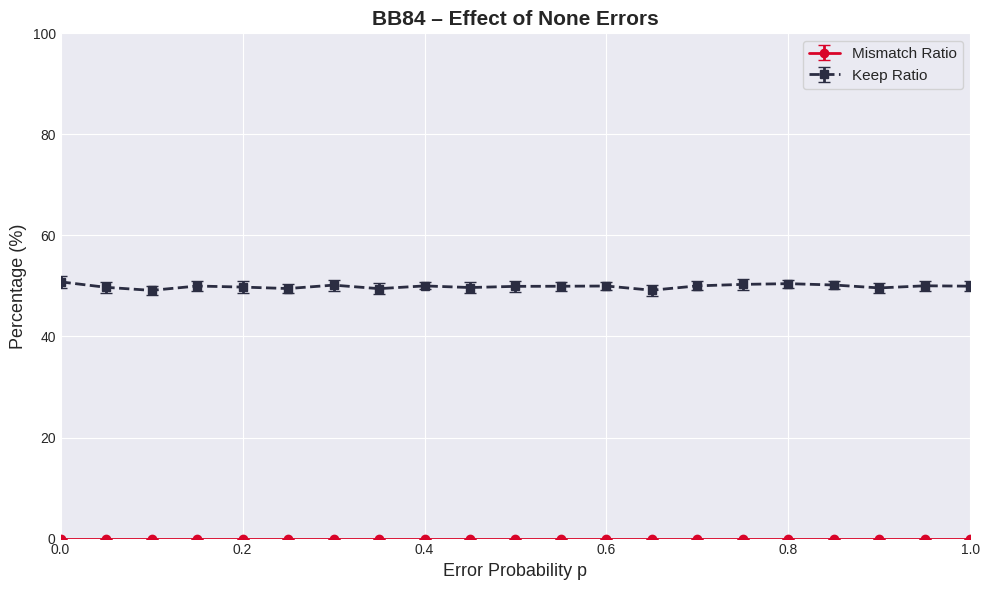

In [ ]:
plot_mismatch_keep_curve(qc, noise_type=None, p_values=p_values,n_repeats=30, n_shots=300, with_eve=False)

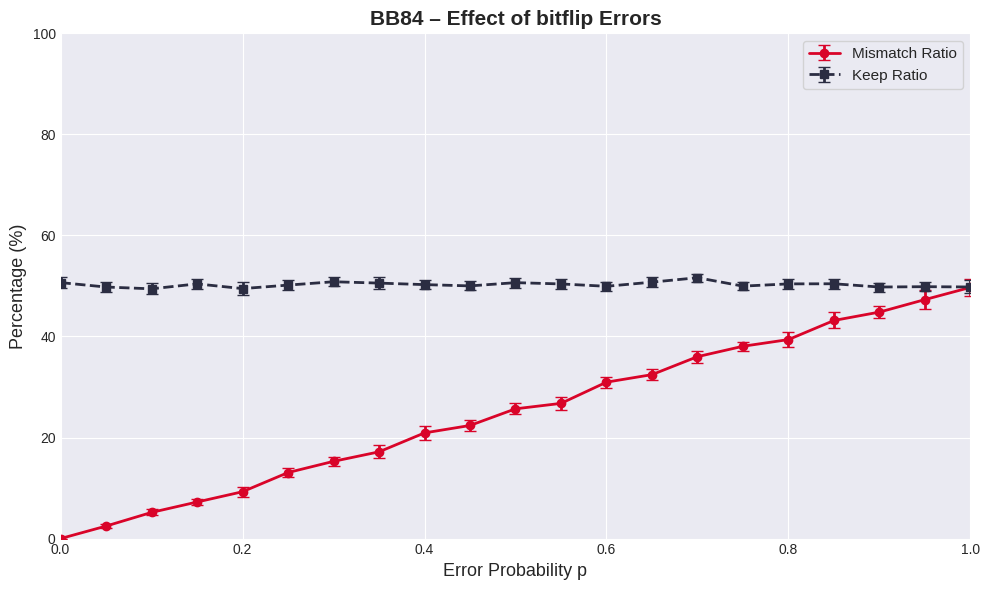

In [ ]:
plot_mismatch_keep_curve(qc, noise_type="bitflip", p_values=p_values,n_repeats=30, n_shots=300, with_eve=False)

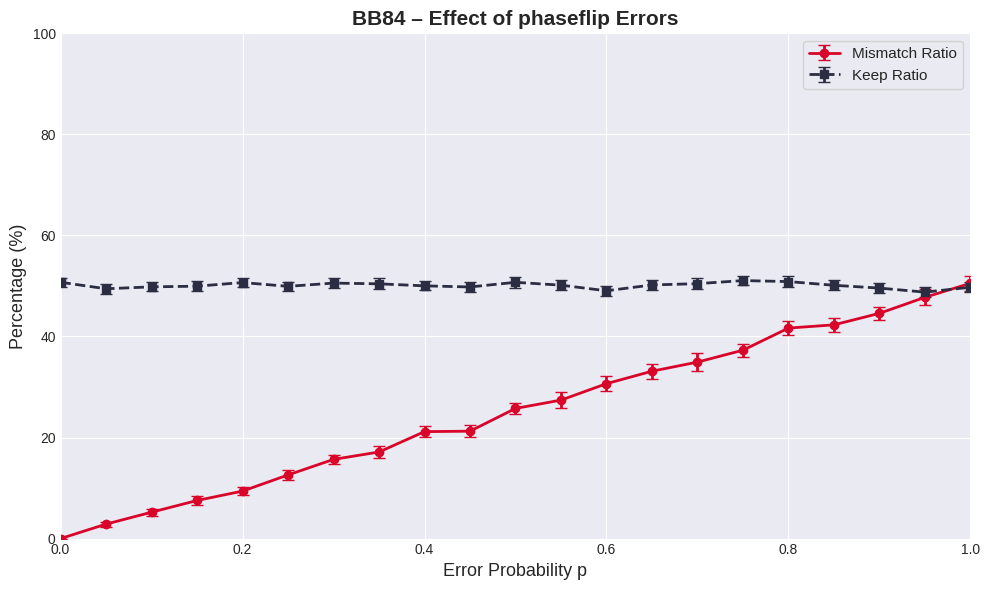

In [ ]:
plot_mismatch_keep_curve(qc, noise_type="phaseflip", p_values=p_values,n_repeats=30, n_shots=300, with_eve=False)

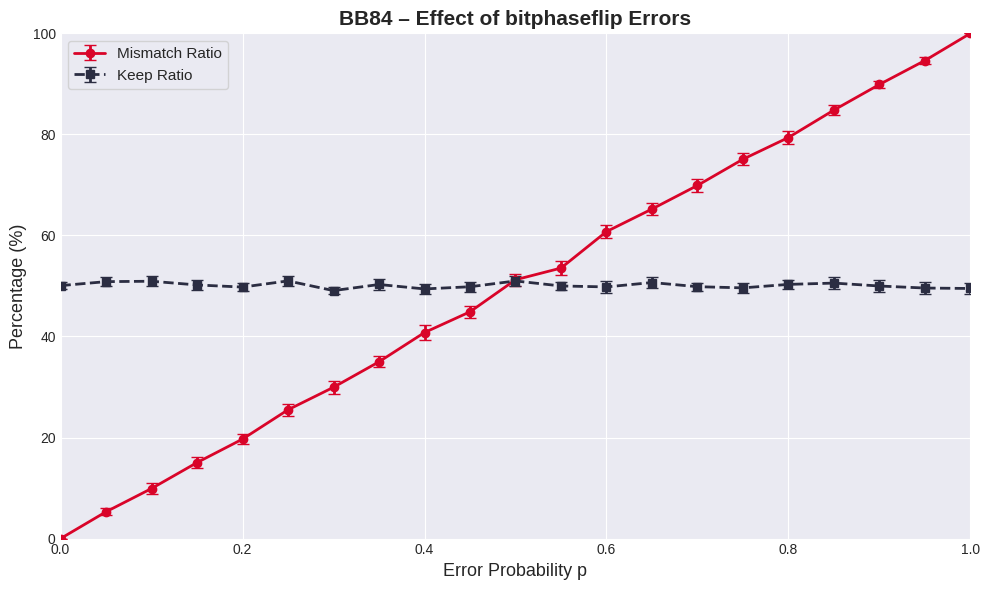

In [ ]:
plot_mismatch_keep_curve(qc, noise_type="bitphaseflip", p_values=p_values,n_repeats=30, n_shots=300, with_eve=False)

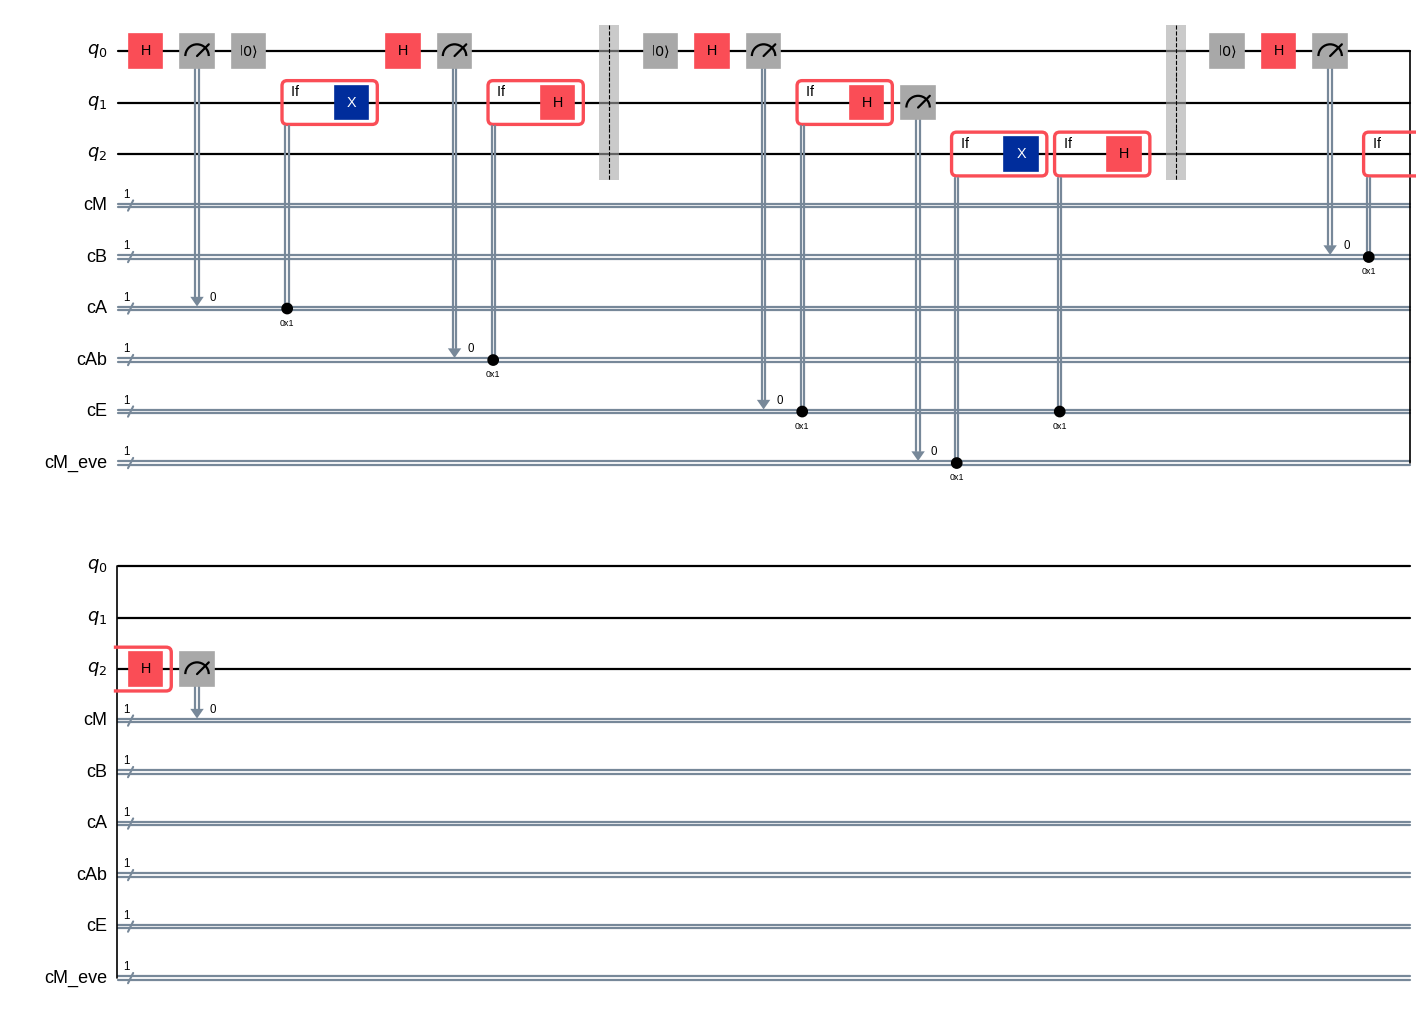

In [ ]:
qc = build_bb84(with_eve=True, draw=True)
display(qc.draw('mpl', idle_wires=False, scale=0.8))

In [ ]:
qc = build_bb84(with_eve=True, draw=False)
p_values = np.arange(0, 1.05, 0.05)

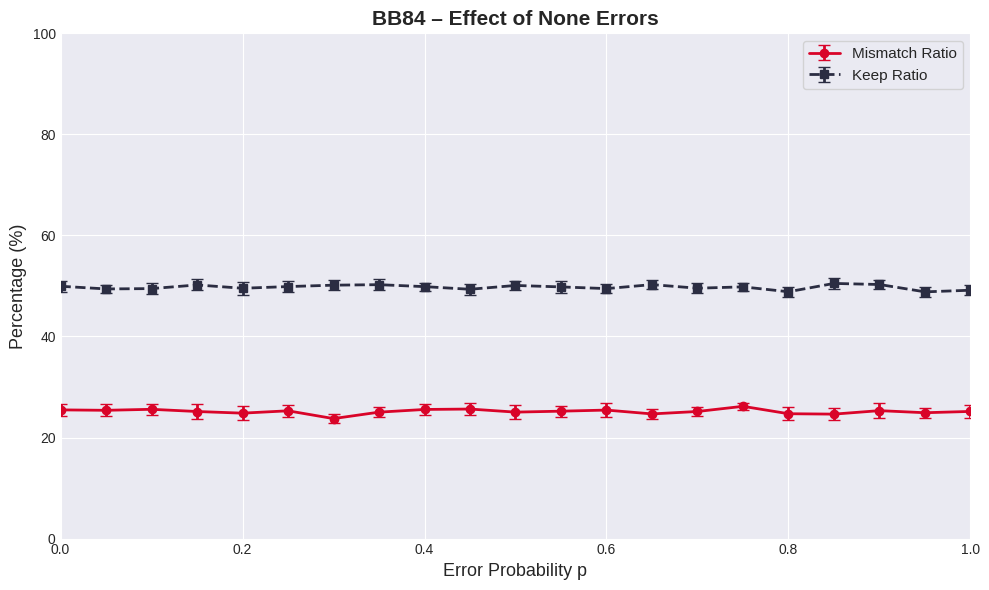

In [ ]:
plot_mismatch_keep_curve(qc, noise_type=None, p_values=p_values,n_repeats=30, n_shots=300, with_eve=True)

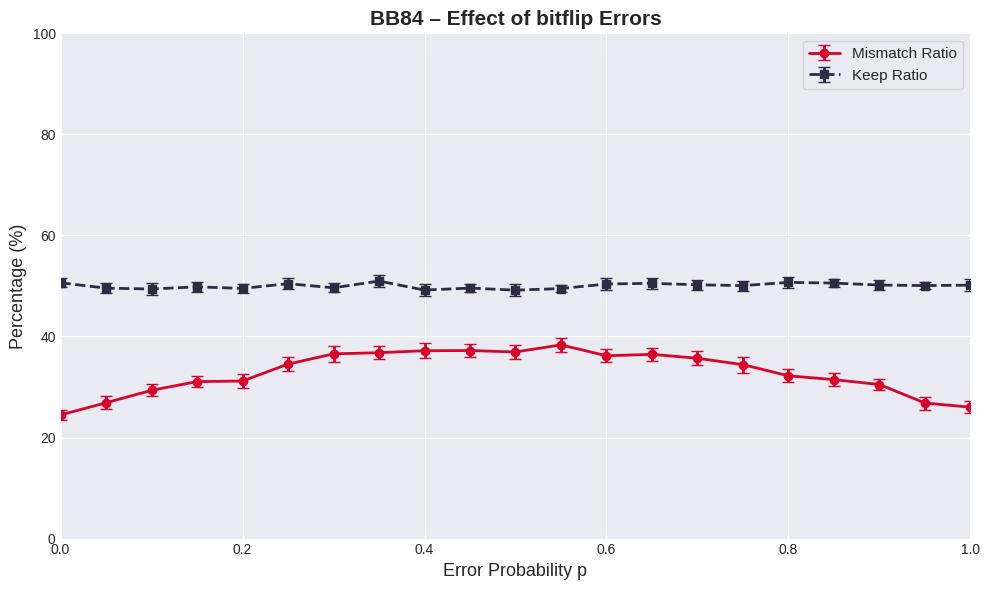

In [ ]:
plot_mismatch_keep_curve(qc, noise_type="bitflip", p_values=p_values,n_repeats=30, n_shots=300, with_eve=True)

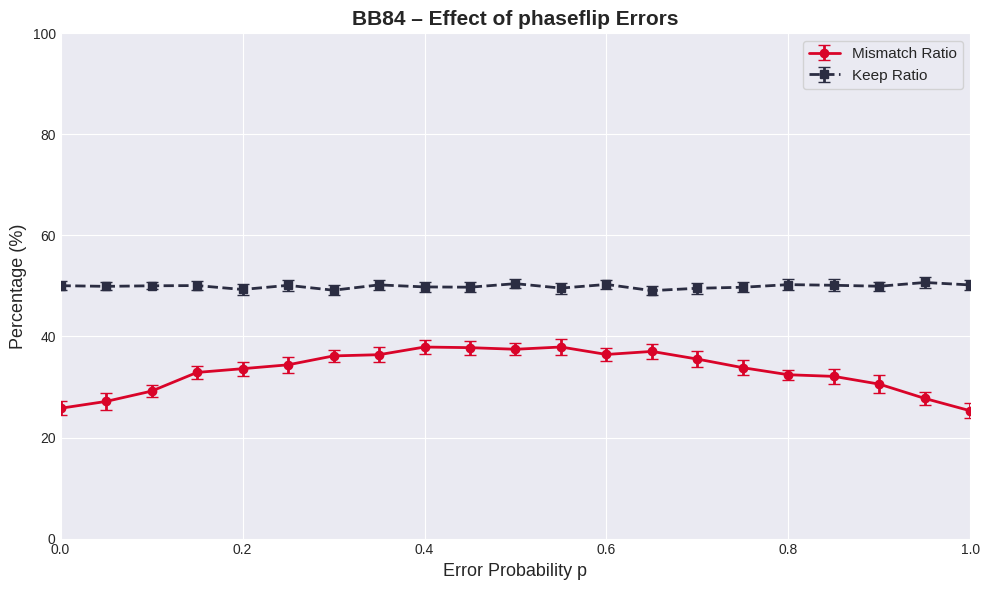

In [ ]:
plot_mismatch_keep_curve(qc, noise_type="phaseflip", p_values=p_values,n_repeats=30, n_shots=300, with_eve=True)

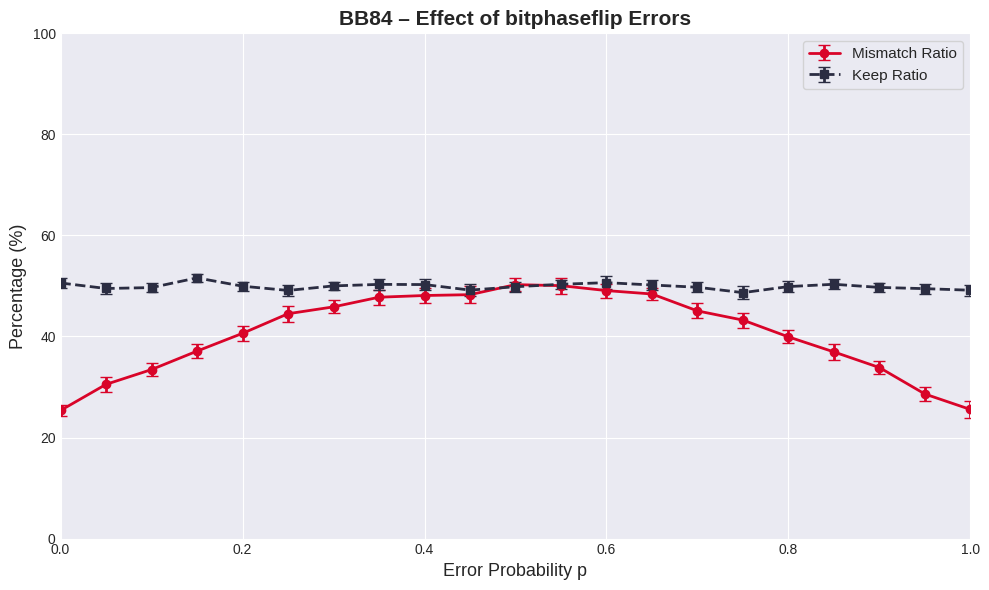

In [ ]:
plot_mismatch_keep_curve(qc, noise_type="bitphaseflip", p_values=p_values,n_repeats=30, n_shots=300, with_eve=True)

In [ ]:
k_values = np.arange(0, 21, 1) / 100

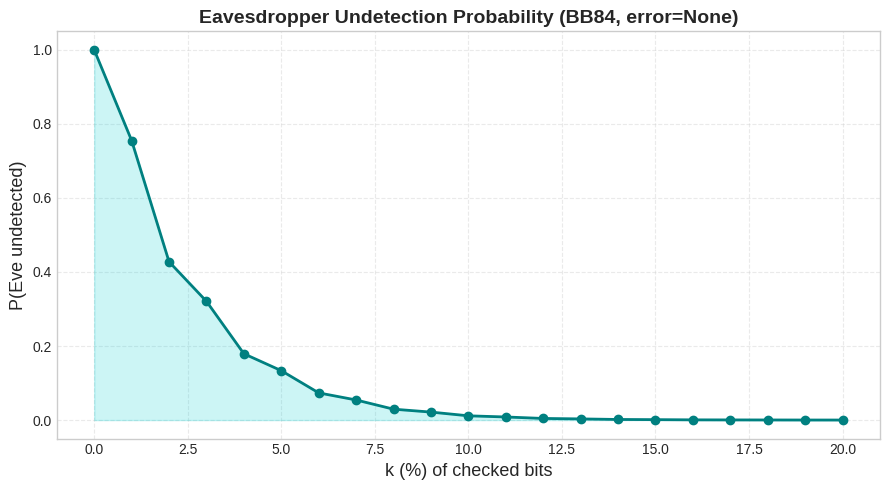

In [ ]:
L, R_mis, _, _,_ = simulate_multiple_times(qc, noise_type=None, p=0, n_repeats=30, n_shots=300, with_eve=True)
R_mis = R_mis/100
plot_p_undetected_vs_k(L, R_mis, k_values, noise_type=None)

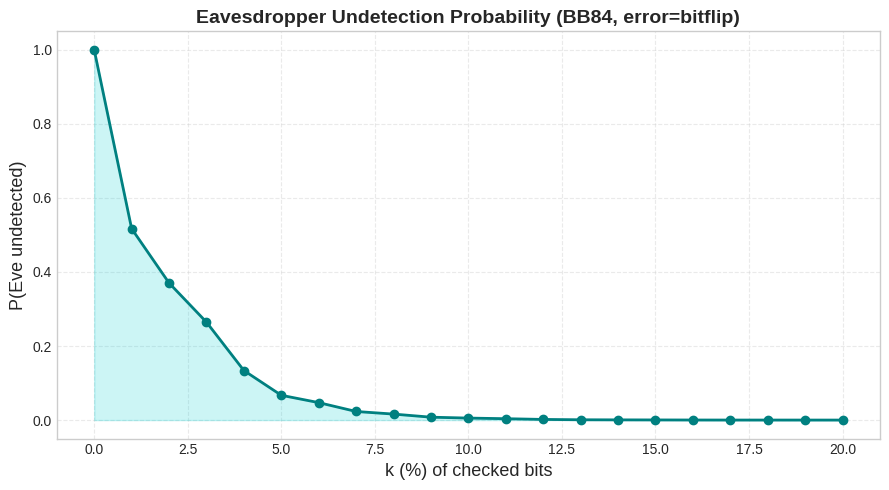

In [ ]:
L, R_mis, _, _,_ = simulate_multiple_times(qc, noise_type='bitflip', p=0.1, n_repeats=30, n_shots=300, with_eve=True)
R_mis = R_mis/100
plot_p_undetected_vs_k(L, R_mis, k_values, noise_type='bitflip')

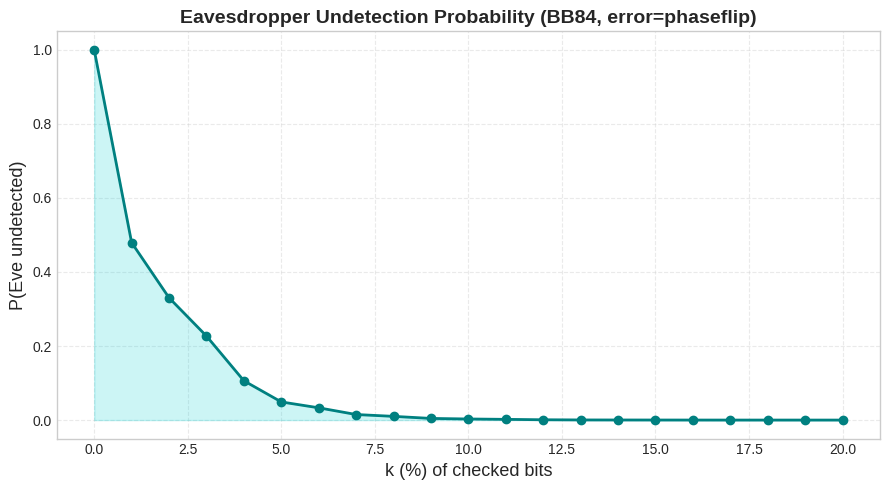

In [ ]:
L, R_mis, _, _,_ = simulate_multiple_times(qc, noise_type='phaseflip', p=0.1, n_repeats=30, n_shots=300, with_eve=True)
R_mis = R_mis/100
plot_p_undetected_vs_k(L, R_mis, k_values, noise_type='phaseflip')

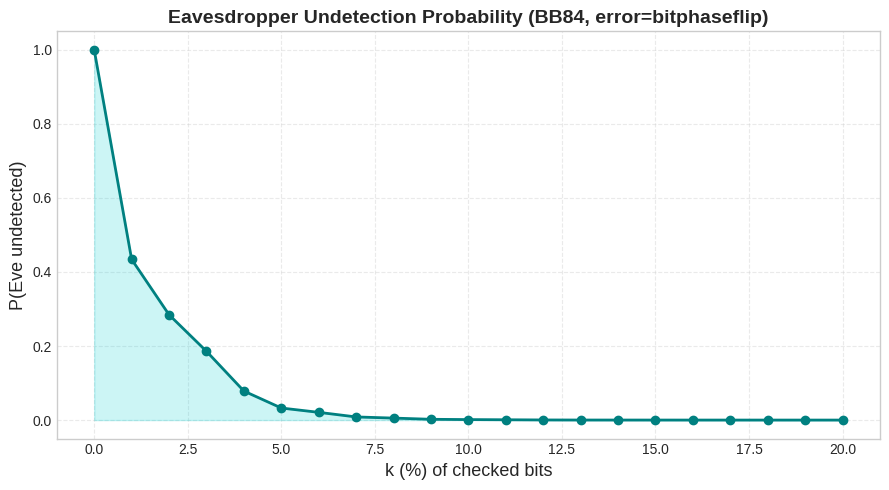

In [ ]:
L, R_mis, _, _,_ = simulate_multiple_times(qc, noise_type='bitphaseflip', p=0.1, n_repeats=30, n_shots=300, with_eve=True)
R_mis = R_mis/100
plot_p_undetected_vs_k(L, R_mis, k_values, noise_type='bitphaseflip')

In [ ]:
qc = build_bb84(with_eve=False)
p_values = np.arange(0, 1.05, 0.05)

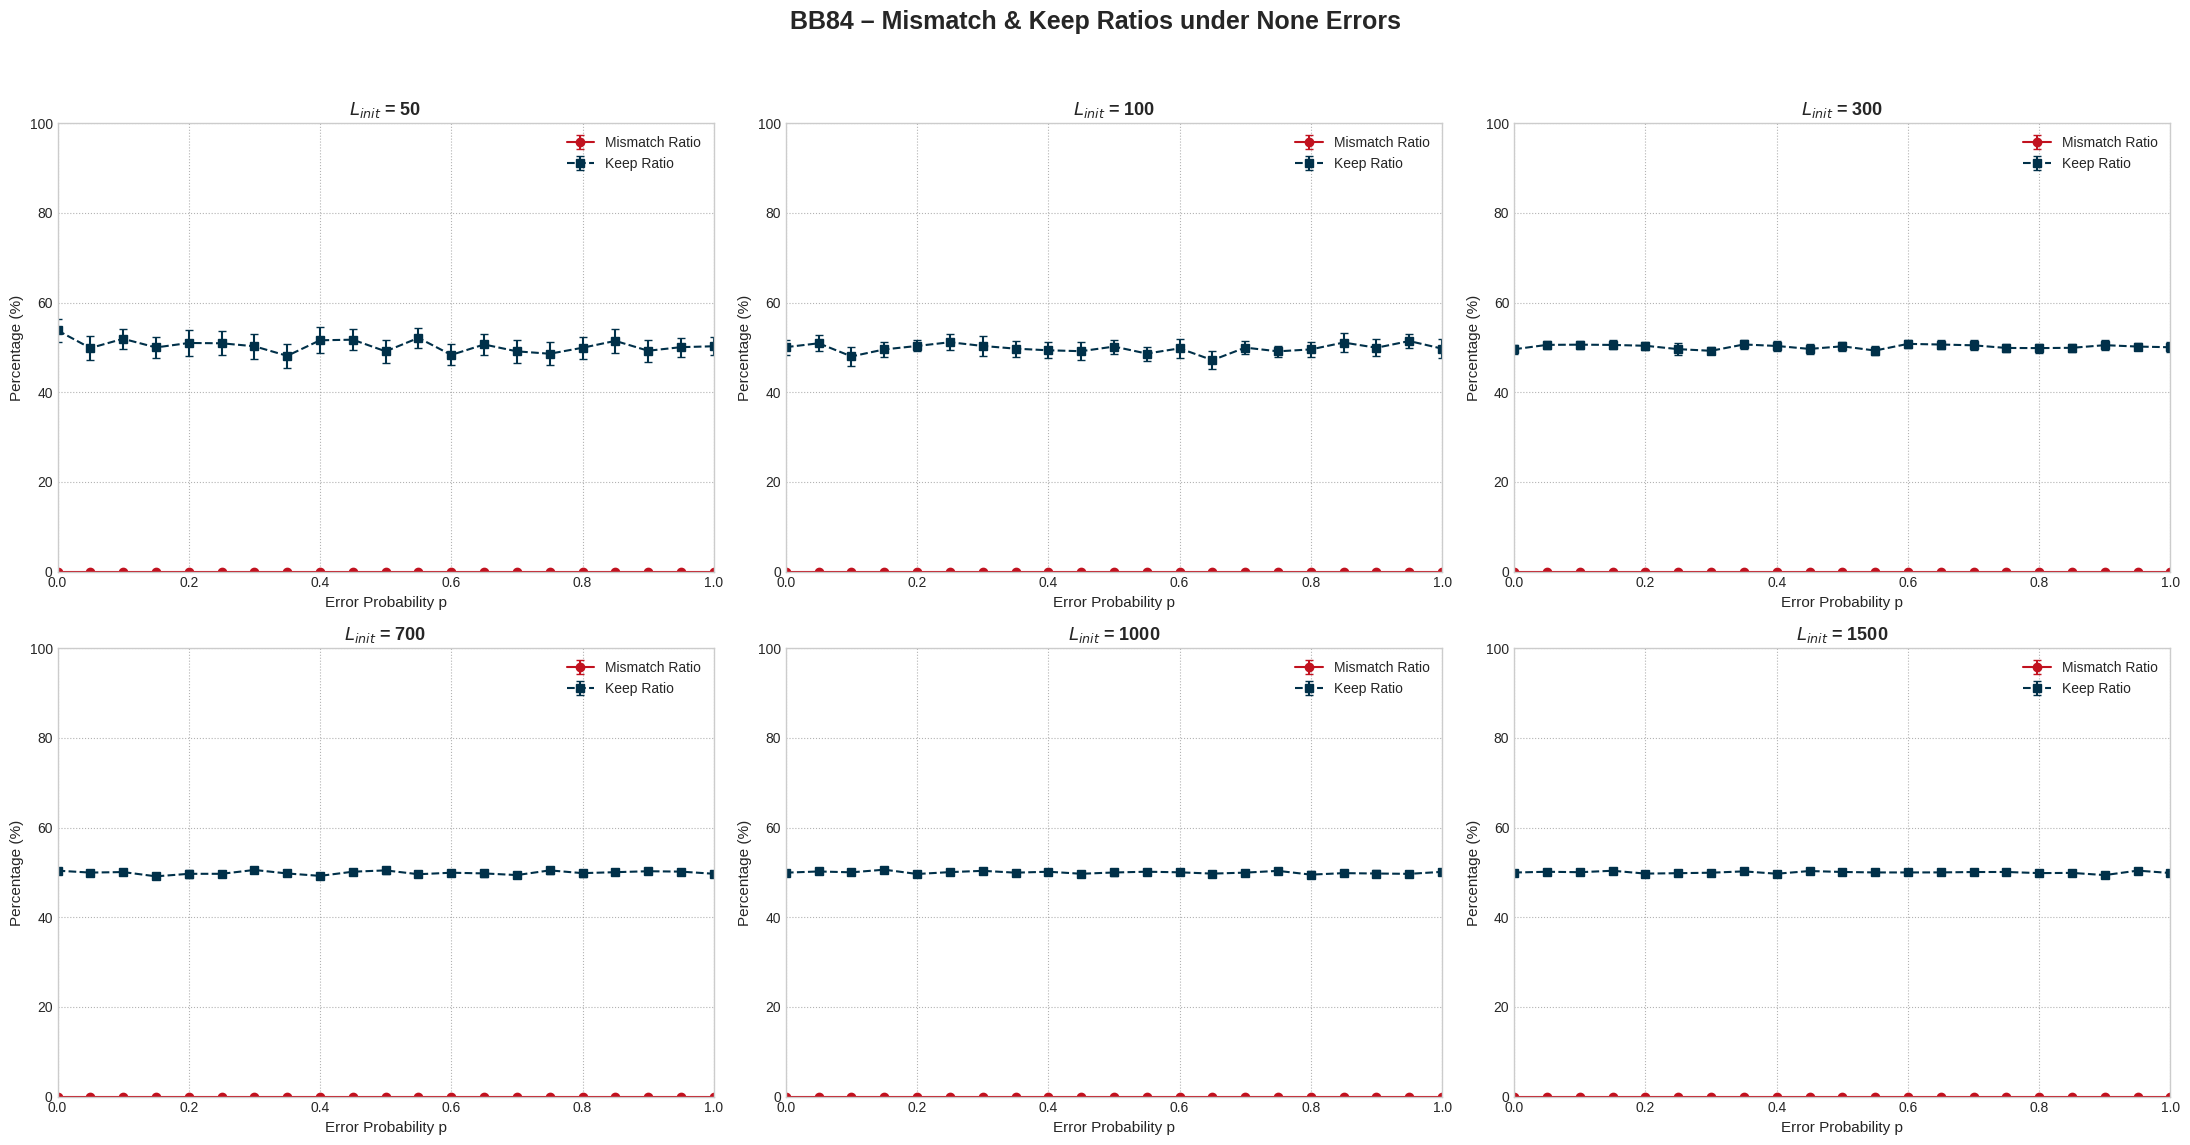

In [ ]:
plot_all_mismatch_keep_curves(qc, None , p_values, n_repeats=30, with_eve=False)

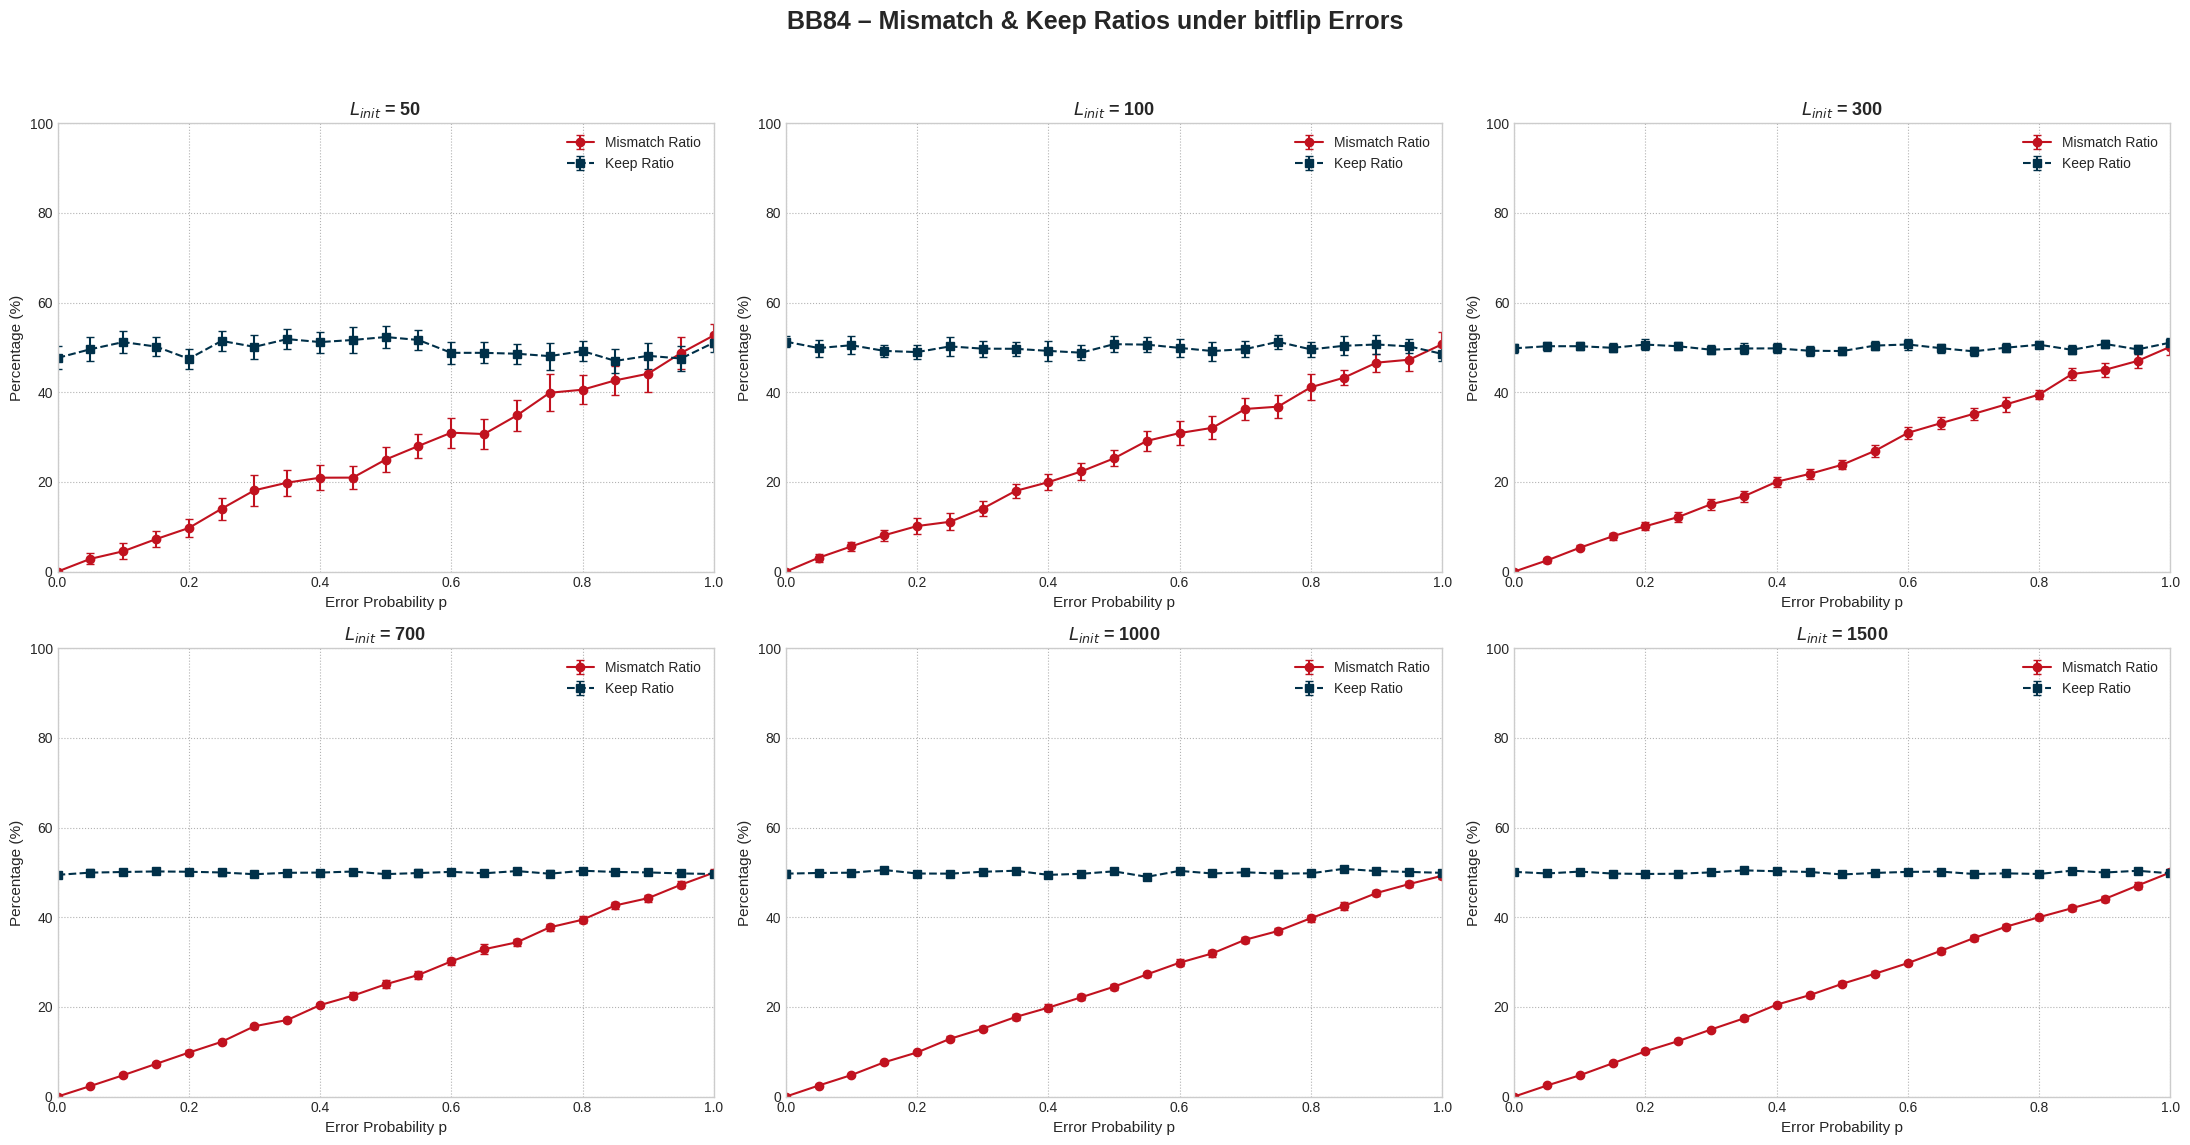

In [ ]:
plot_all_mismatch_keep_curves(qc, "bitflip" , p_values, n_repeats=30, with_eve=False)

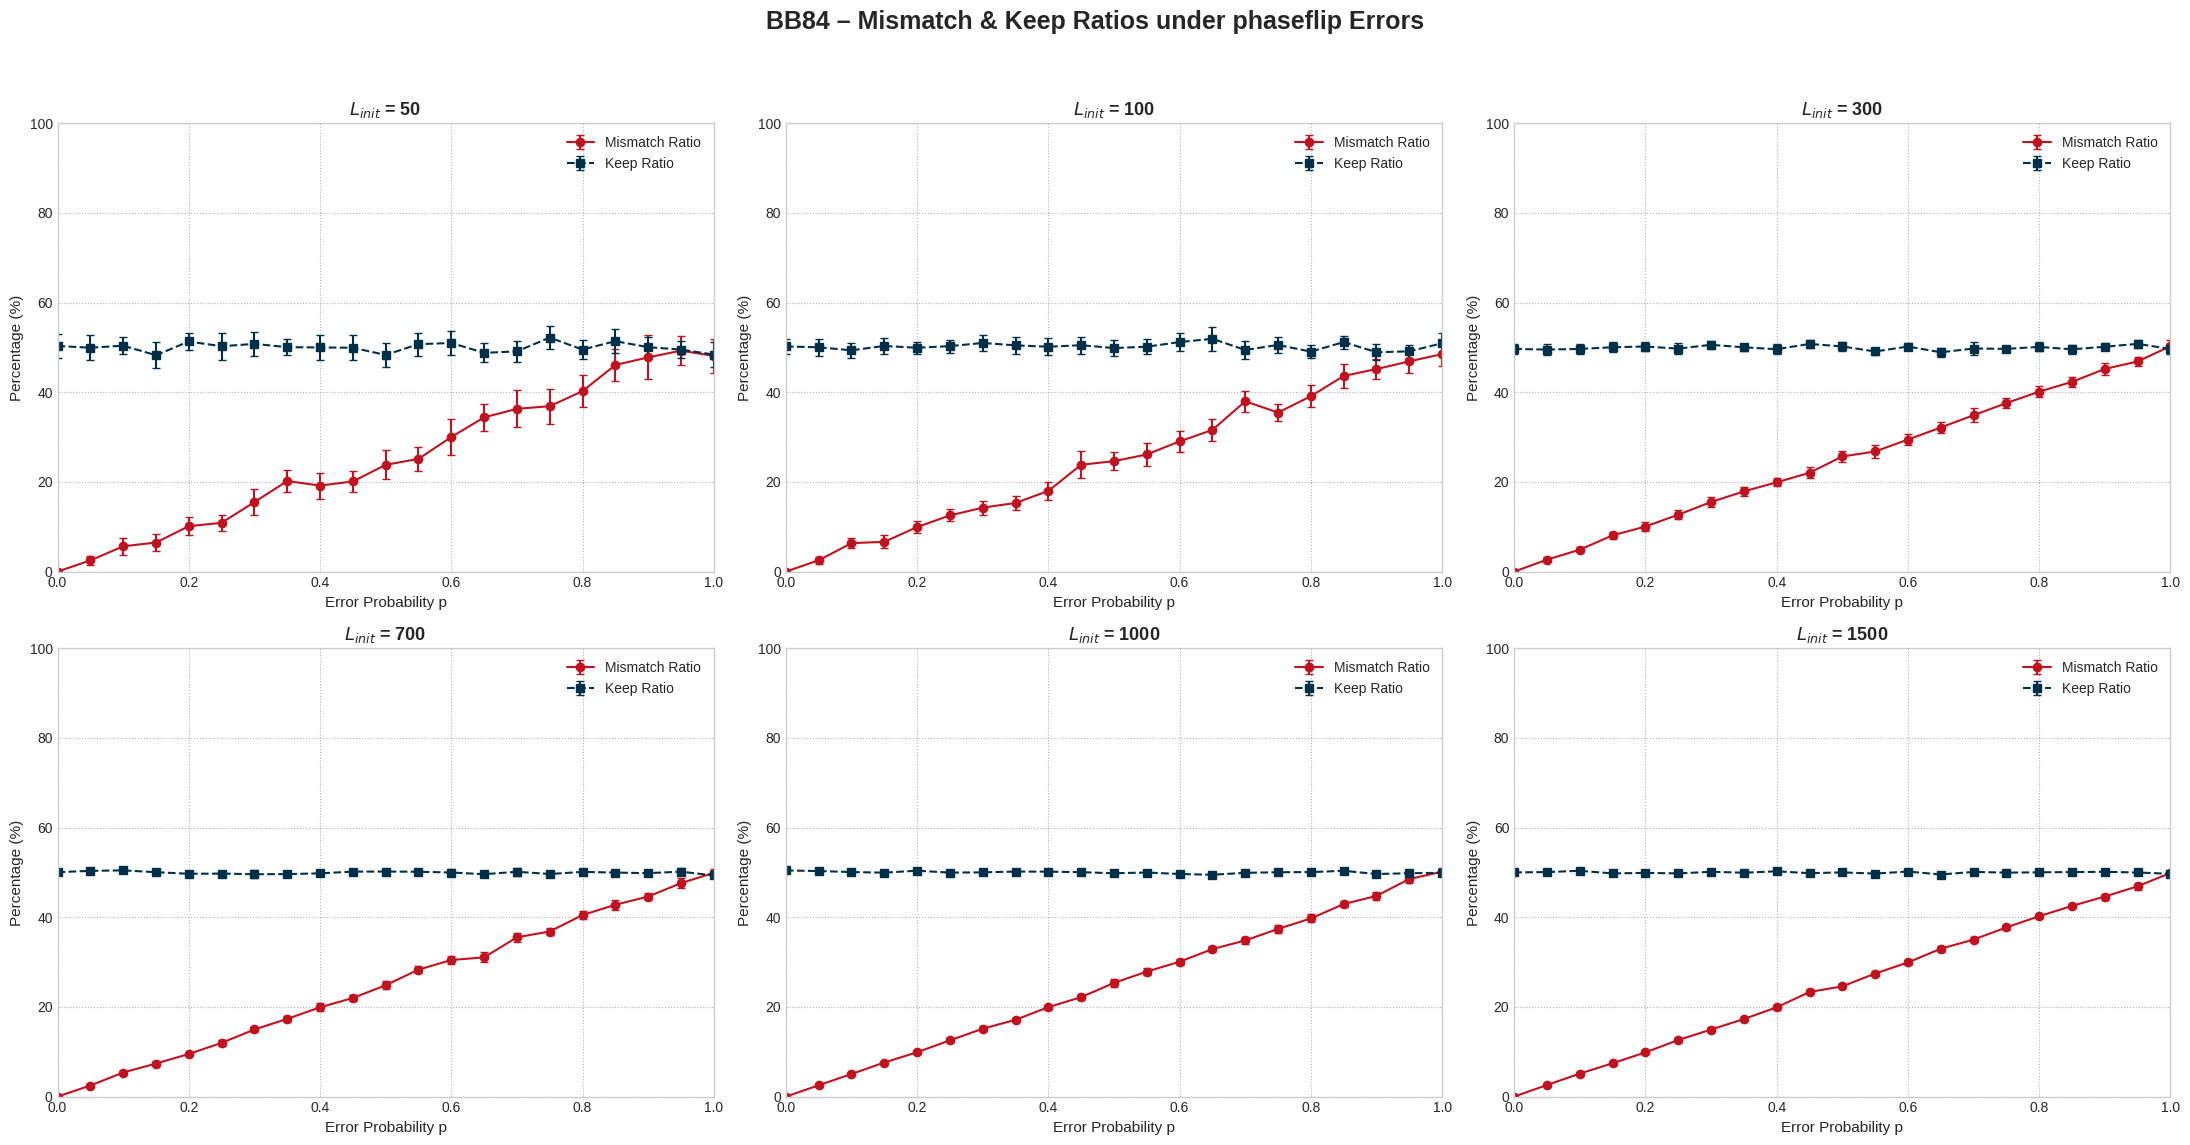

In [ ]:
plot_all_mismatch_keep_curves(qc, "phaseflip" , p_values, n_repeats=30, with_eve=False)

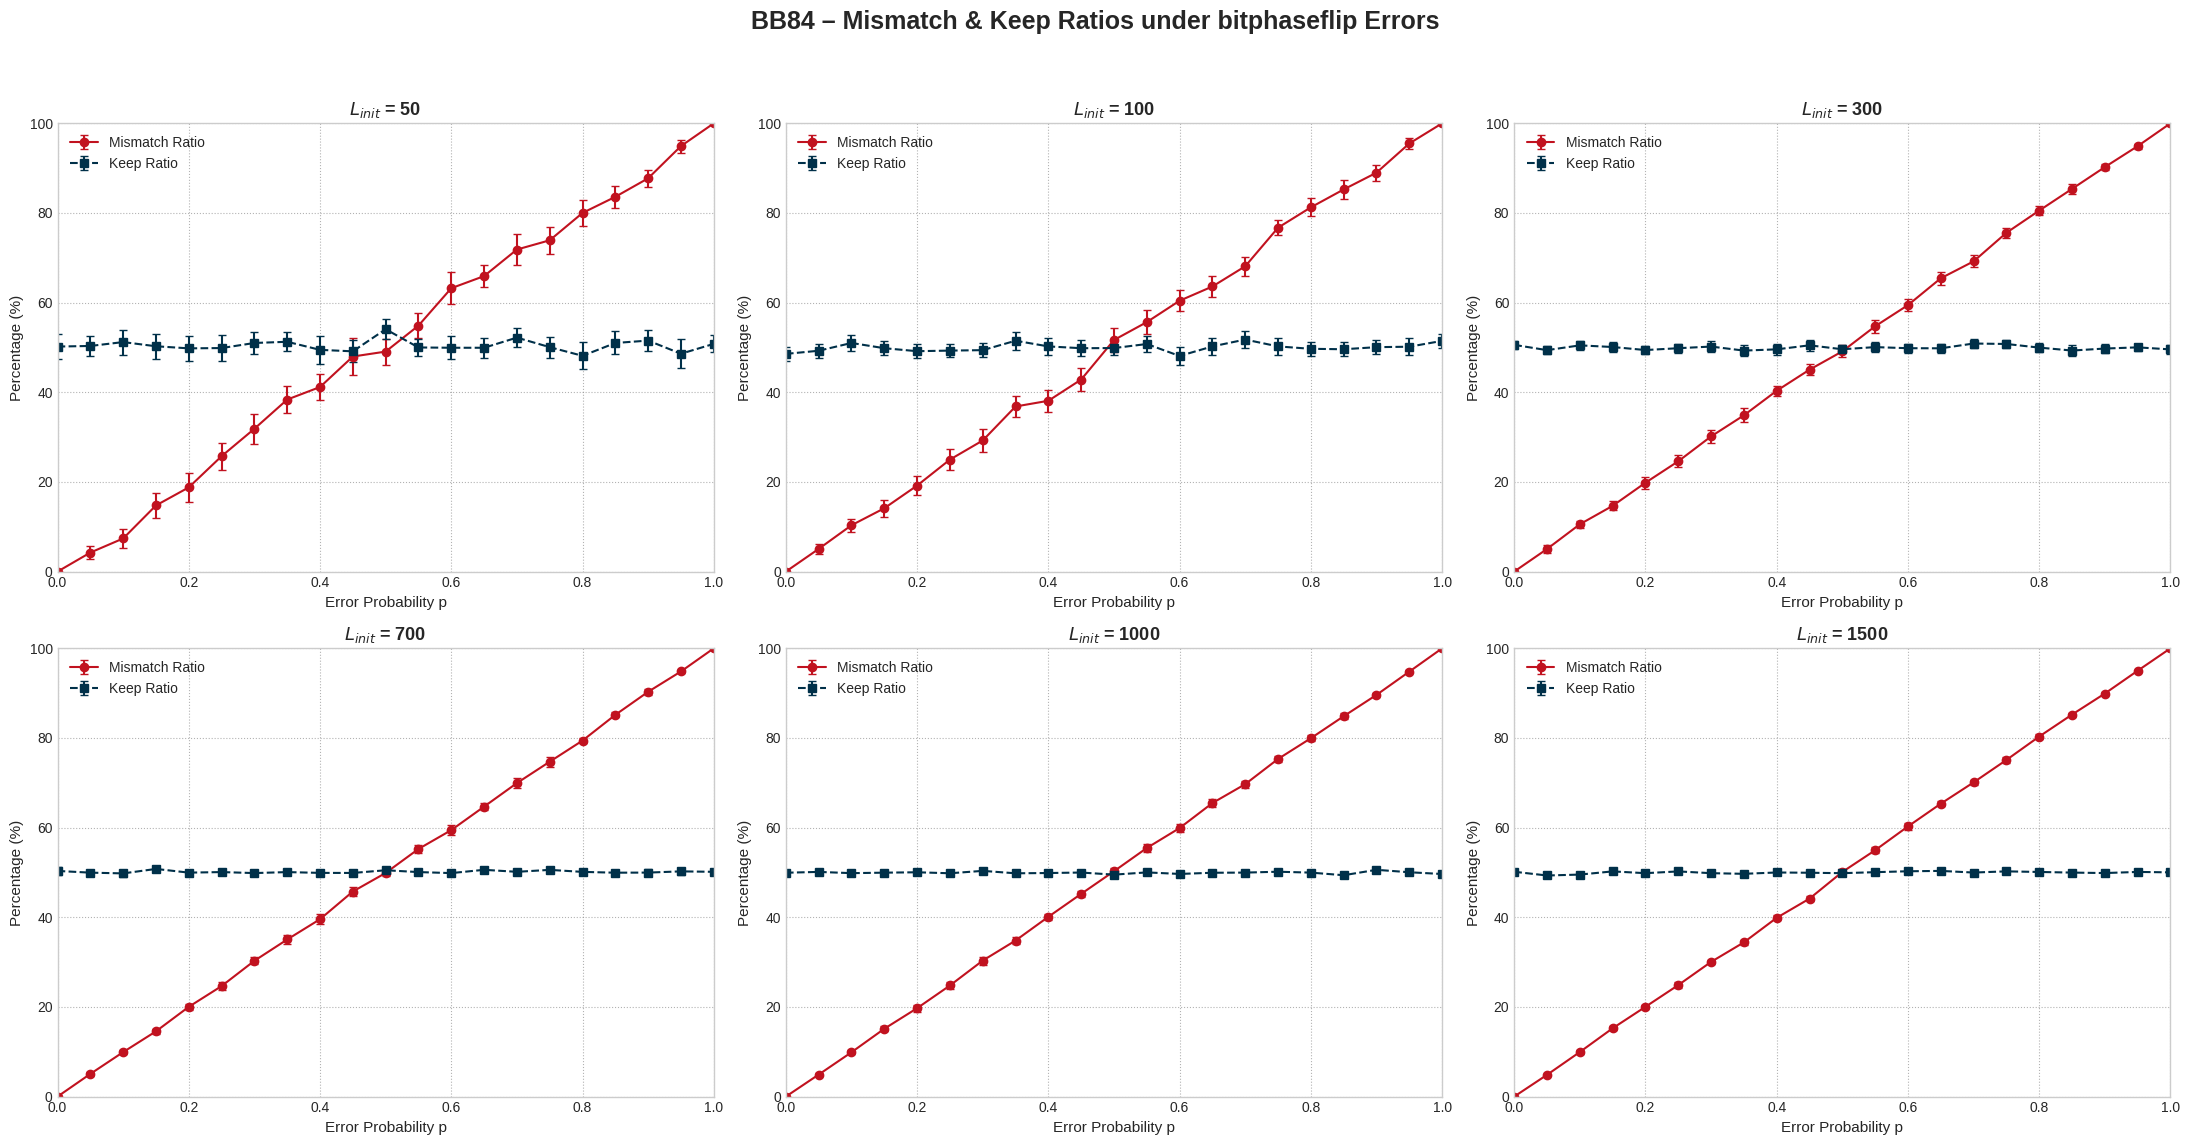

In [ ]:
plot_all_mismatch_keep_curves(qc, "bitphaseflip" , p_values, n_repeats=30, with_eve=False)

In [ ]:
qc = build_bb84(with_eve=True)
p_values = np.arange(0, 1.05, 0.05)

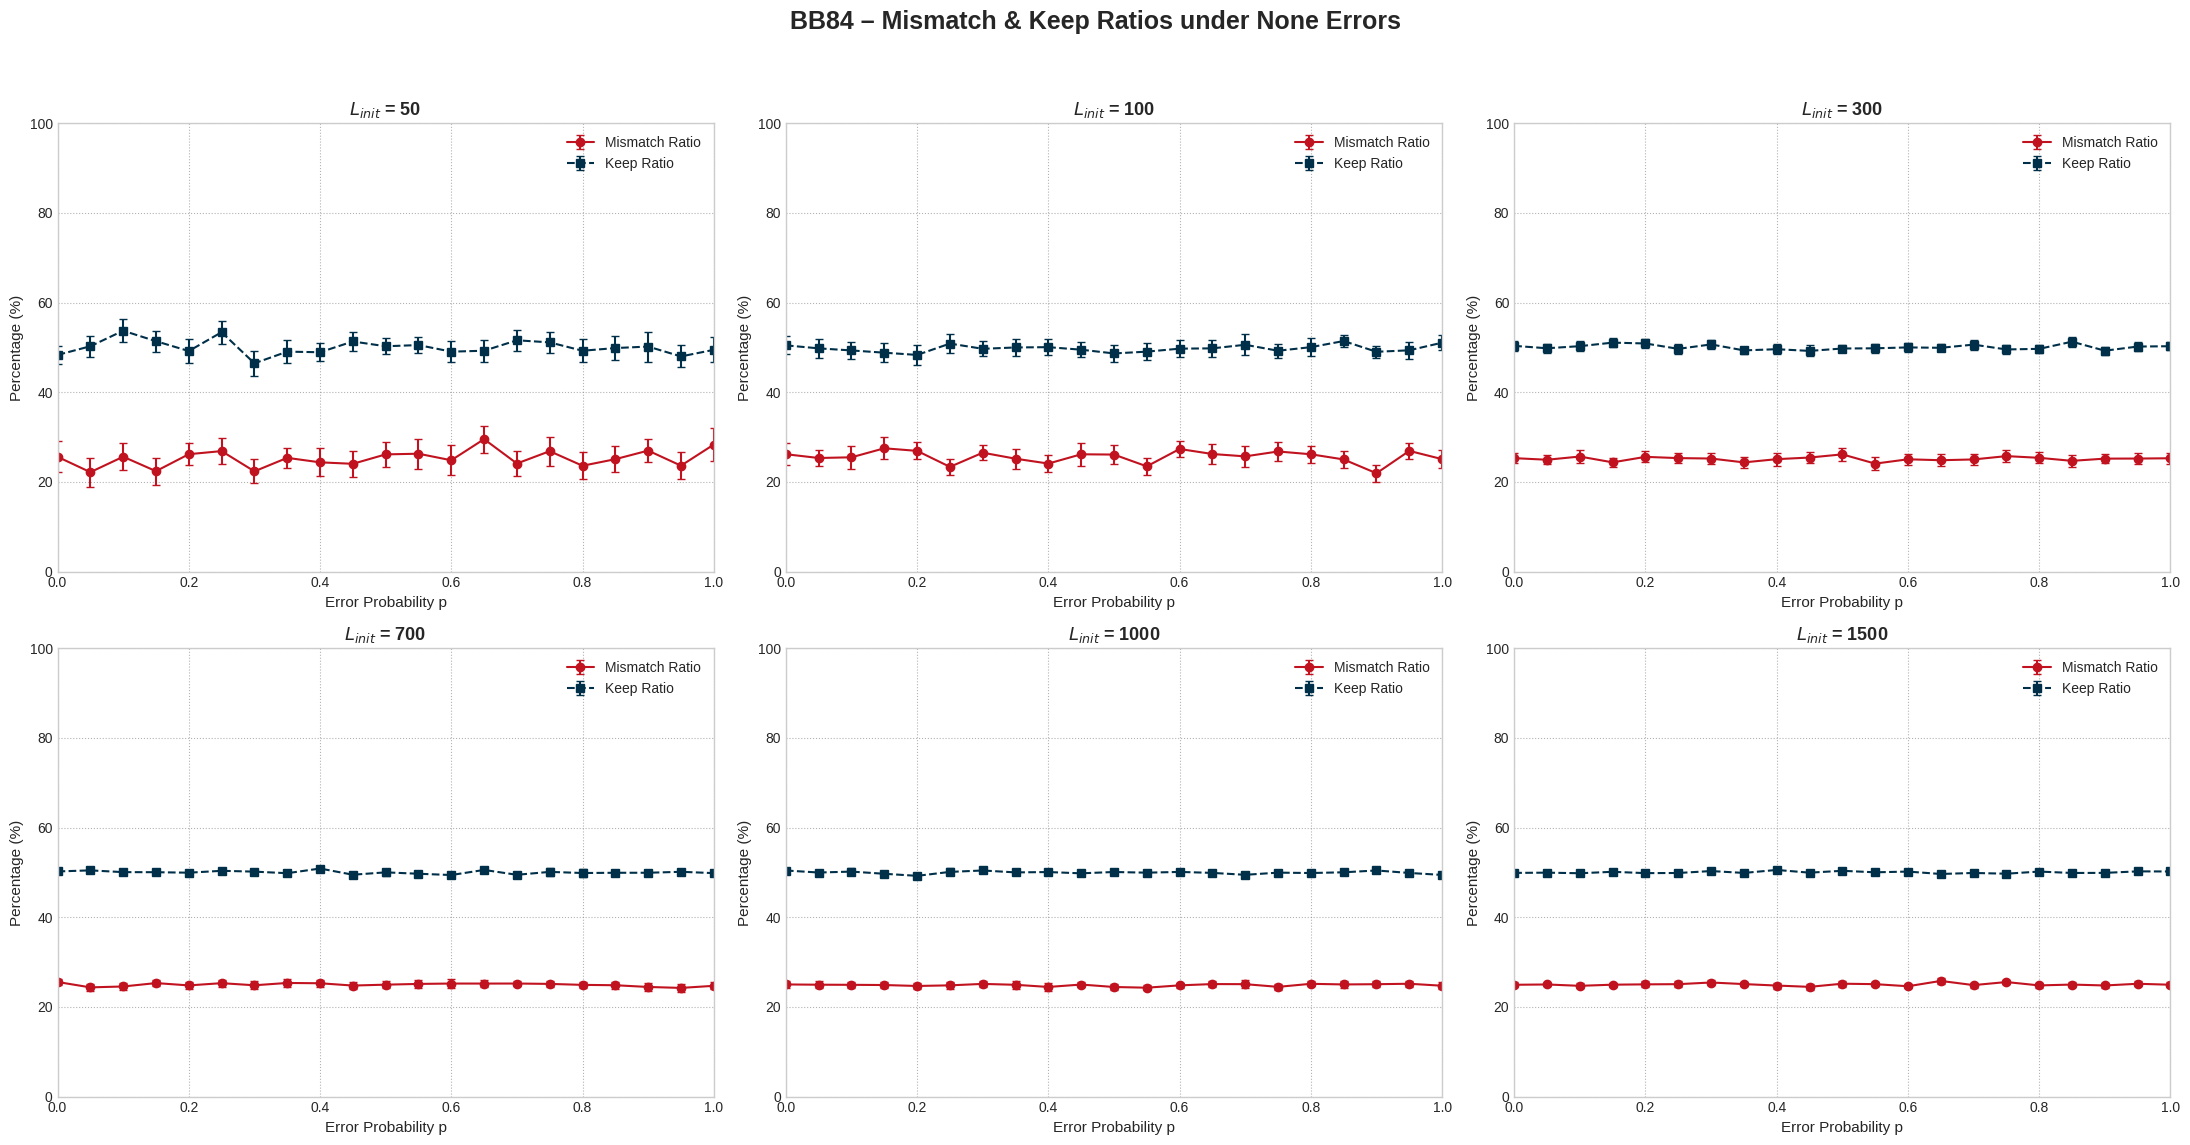

In [ ]:
plot_all_mismatch_keep_curves(qc, None , p_values, n_repeats=30, with_eve=True)

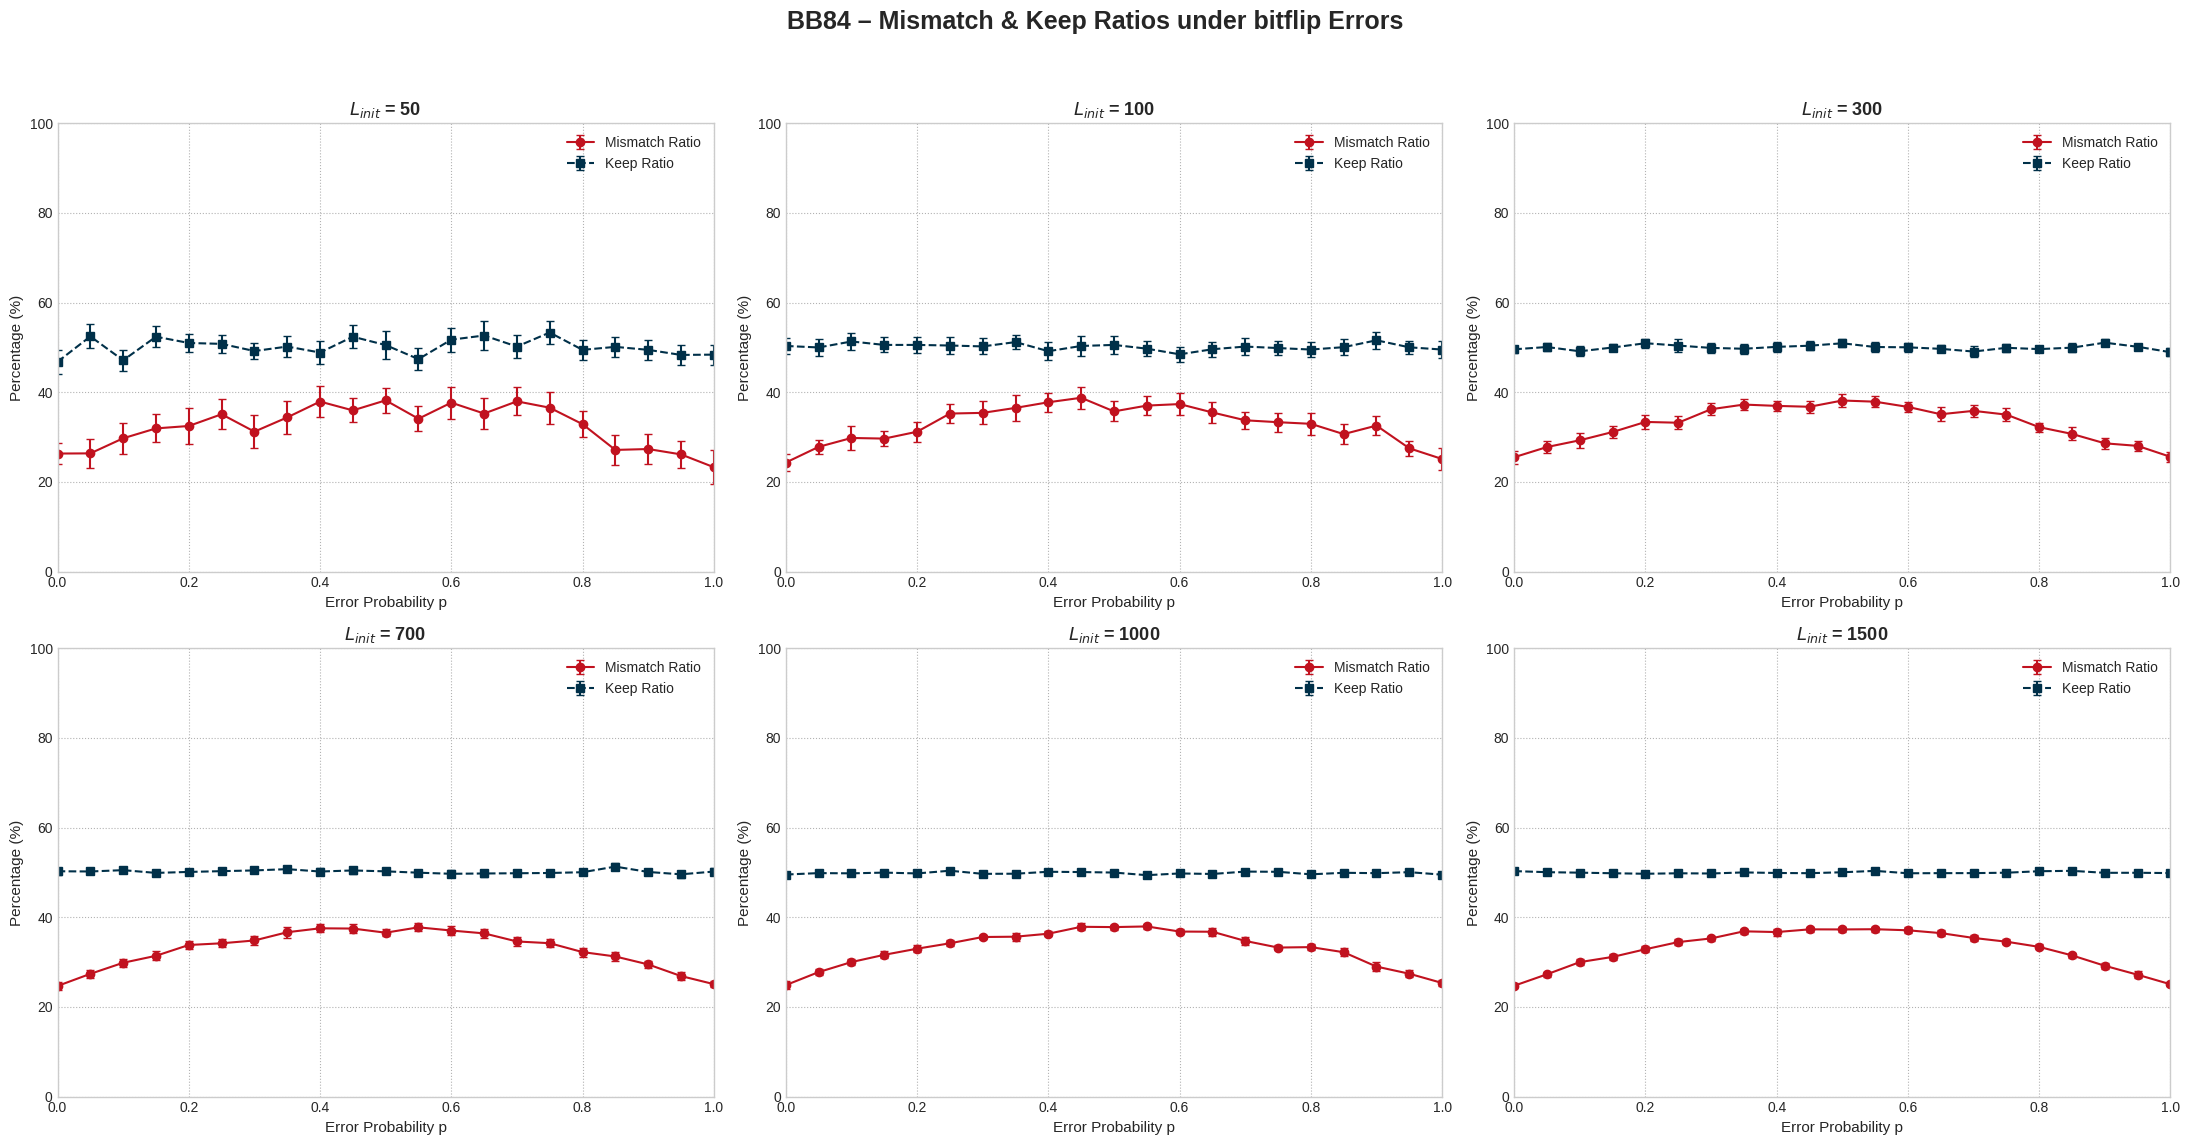

In [ ]:
plot_all_mismatch_keep_curves(qc, "bitflip" , p_values, n_repeats=30, with_eve=True)

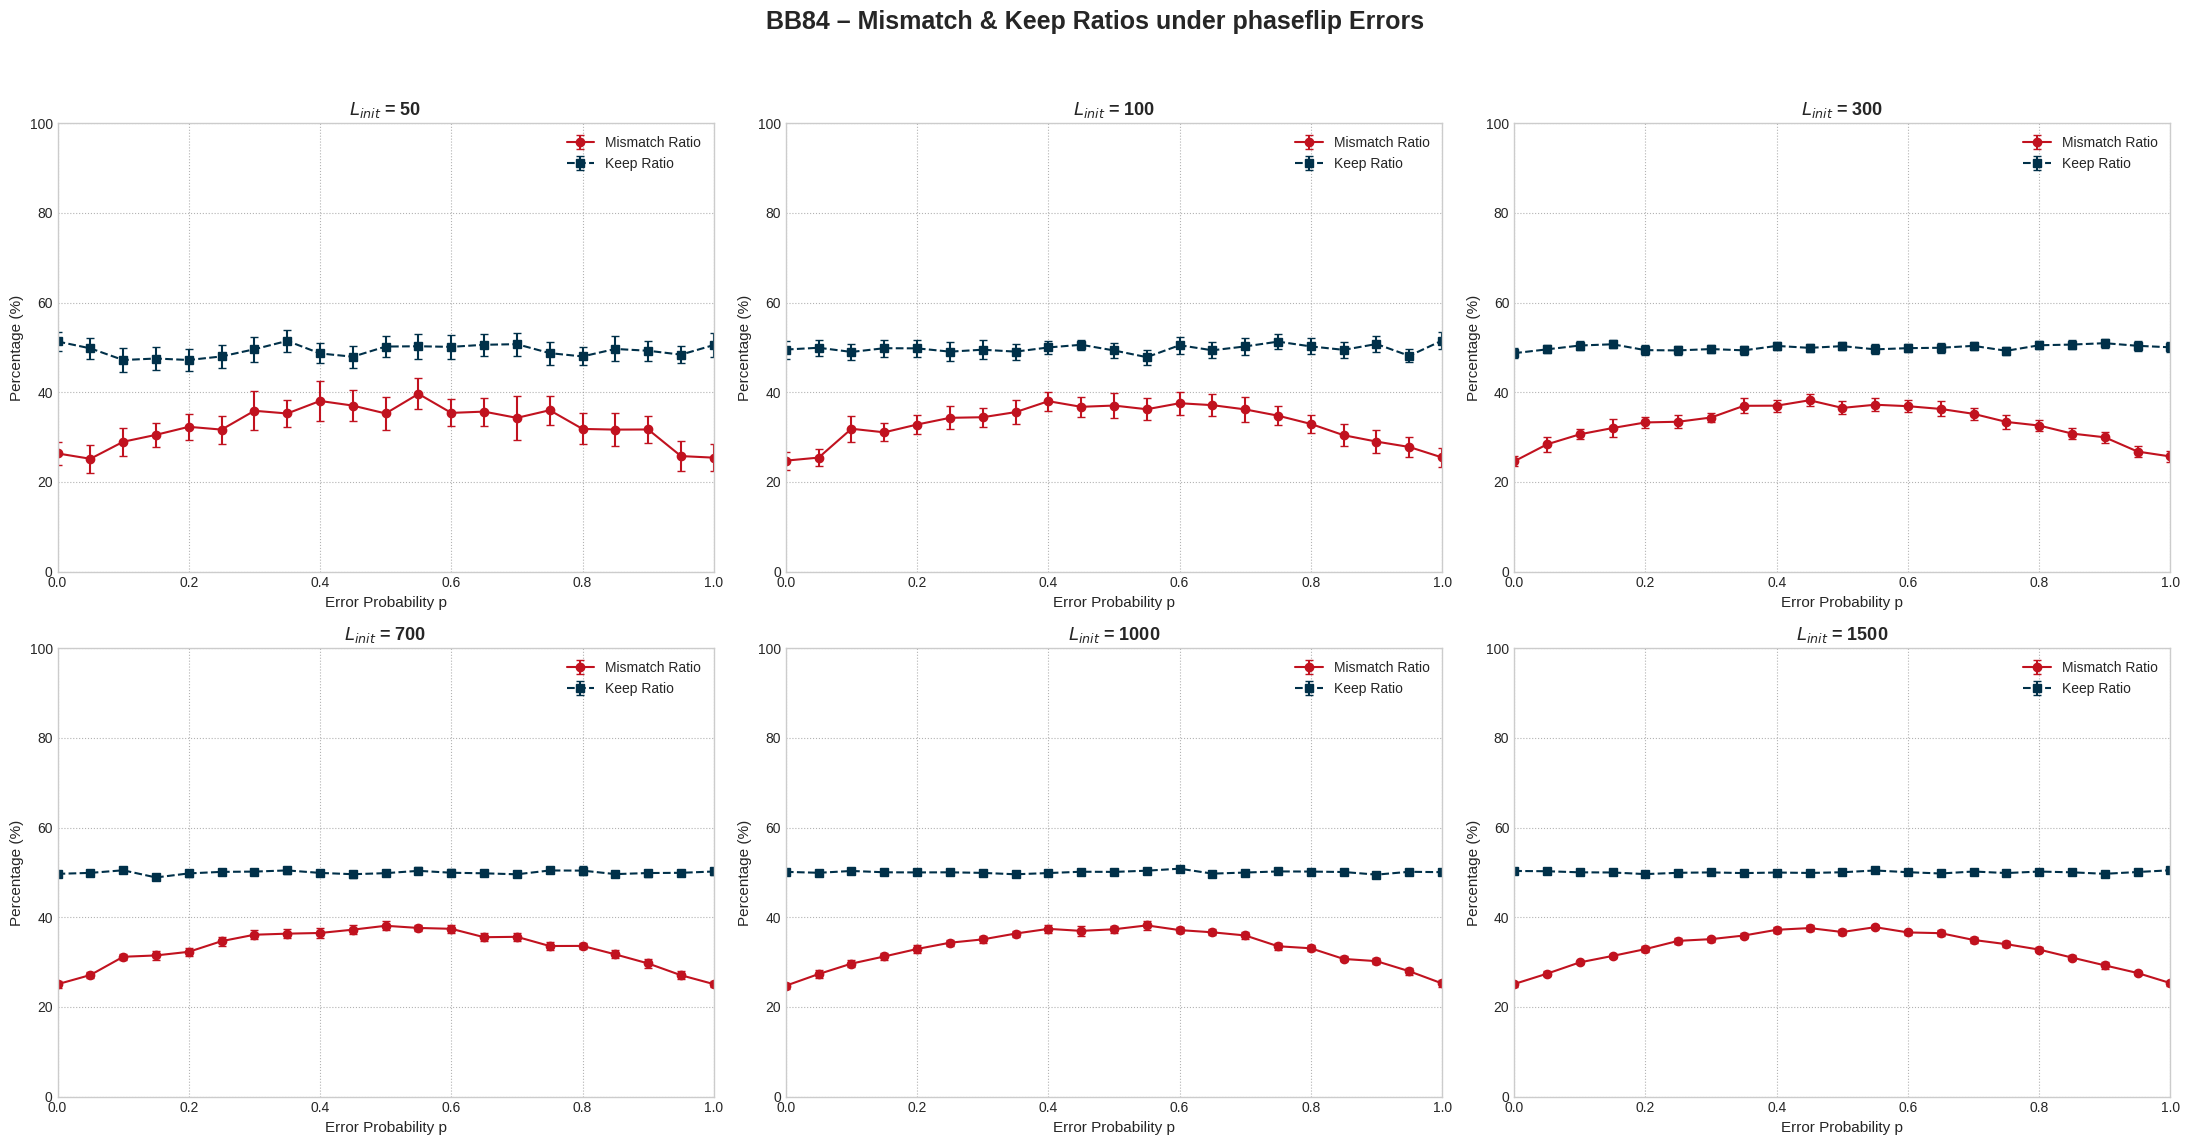

In [ ]:
plot_all_mismatch_keep_curves(qc, "phaseflip" , p_values, n_repeats=30, with_eve=True)

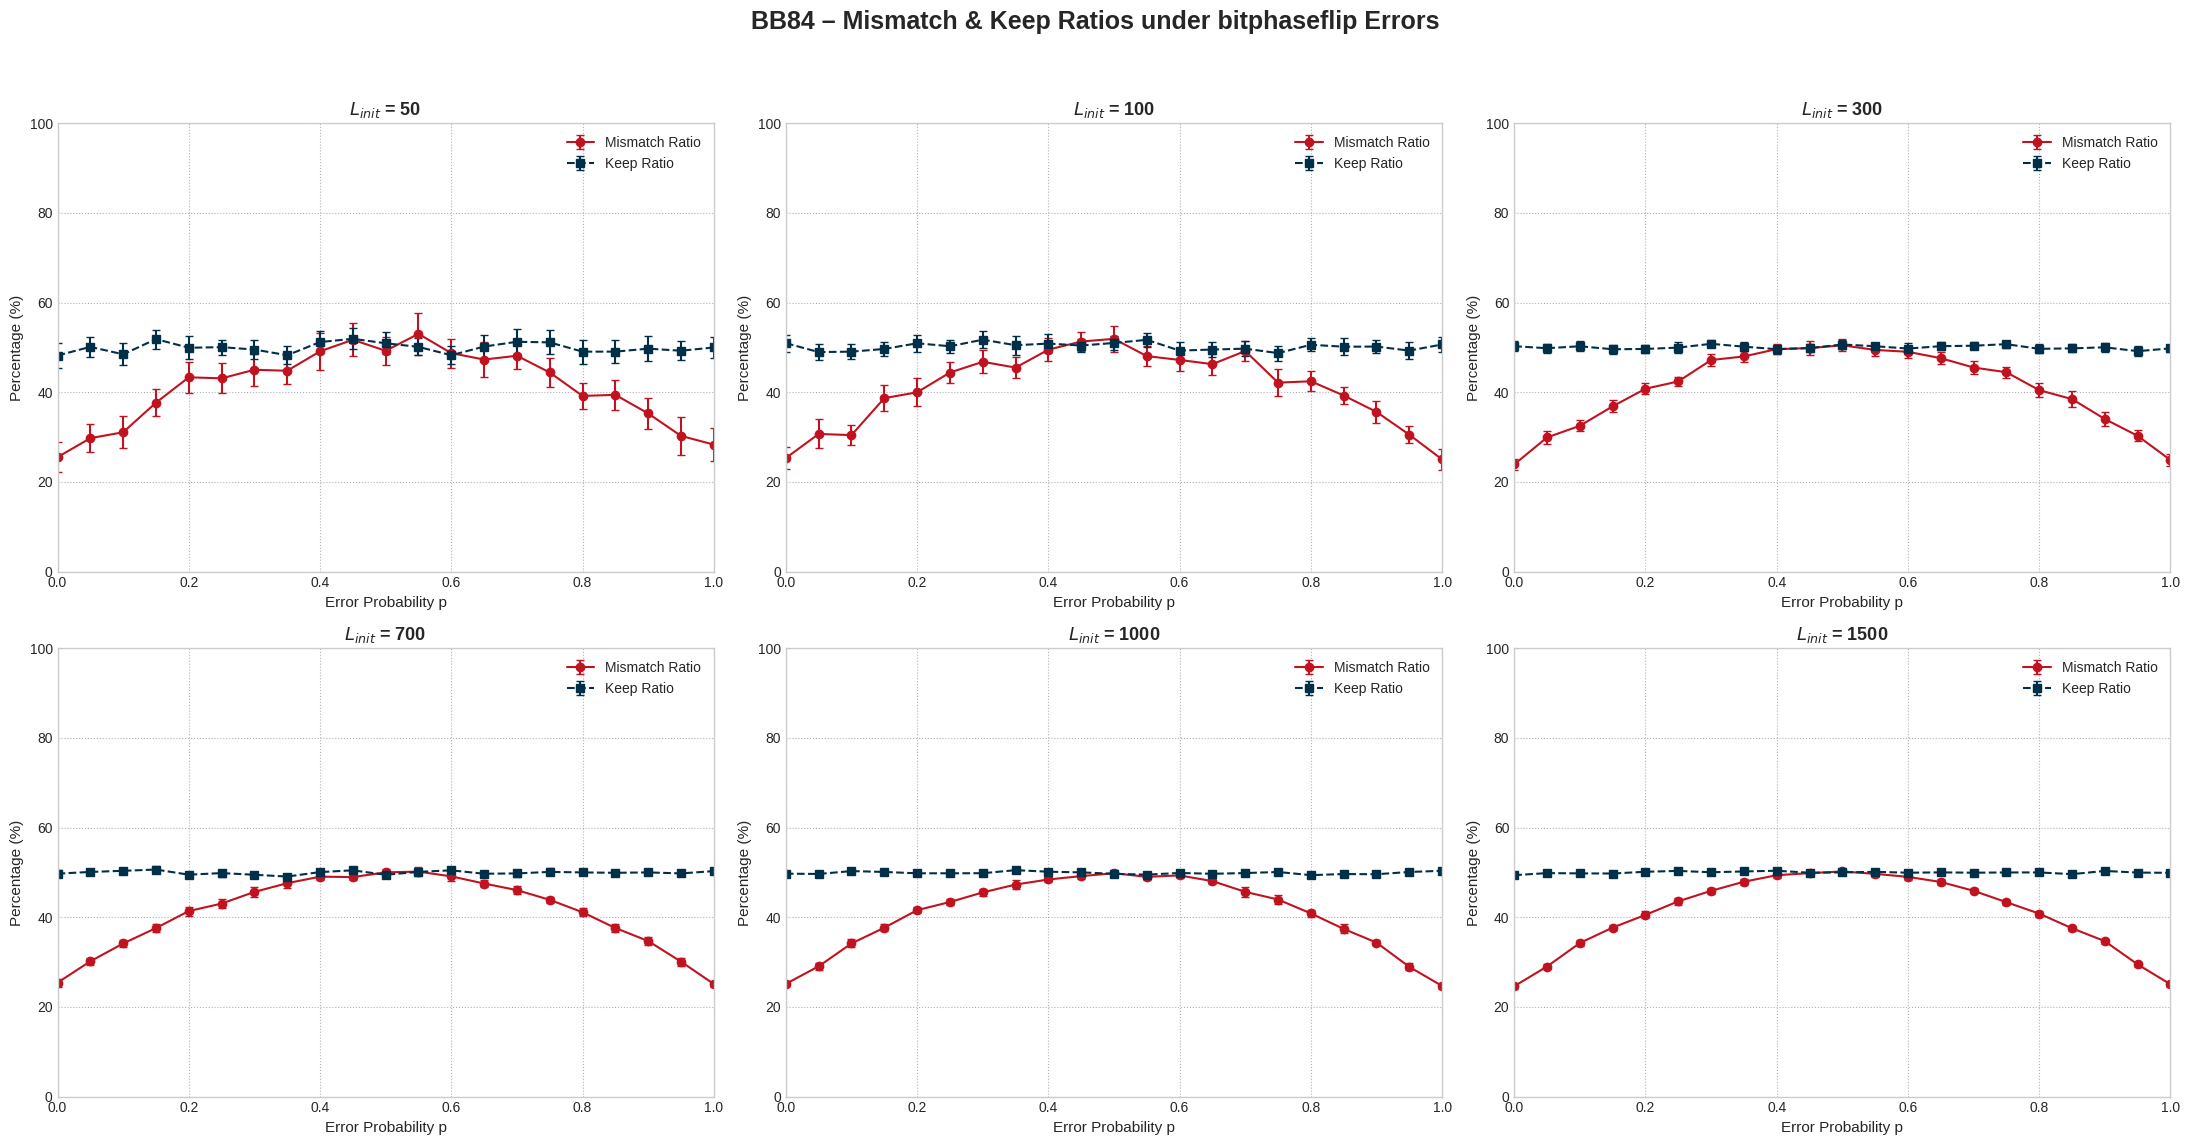

In [ ]:
plot_all_mismatch_keep_curves(qc, "bitphaseflip" , p_values, n_repeats=30, with_eve=True)

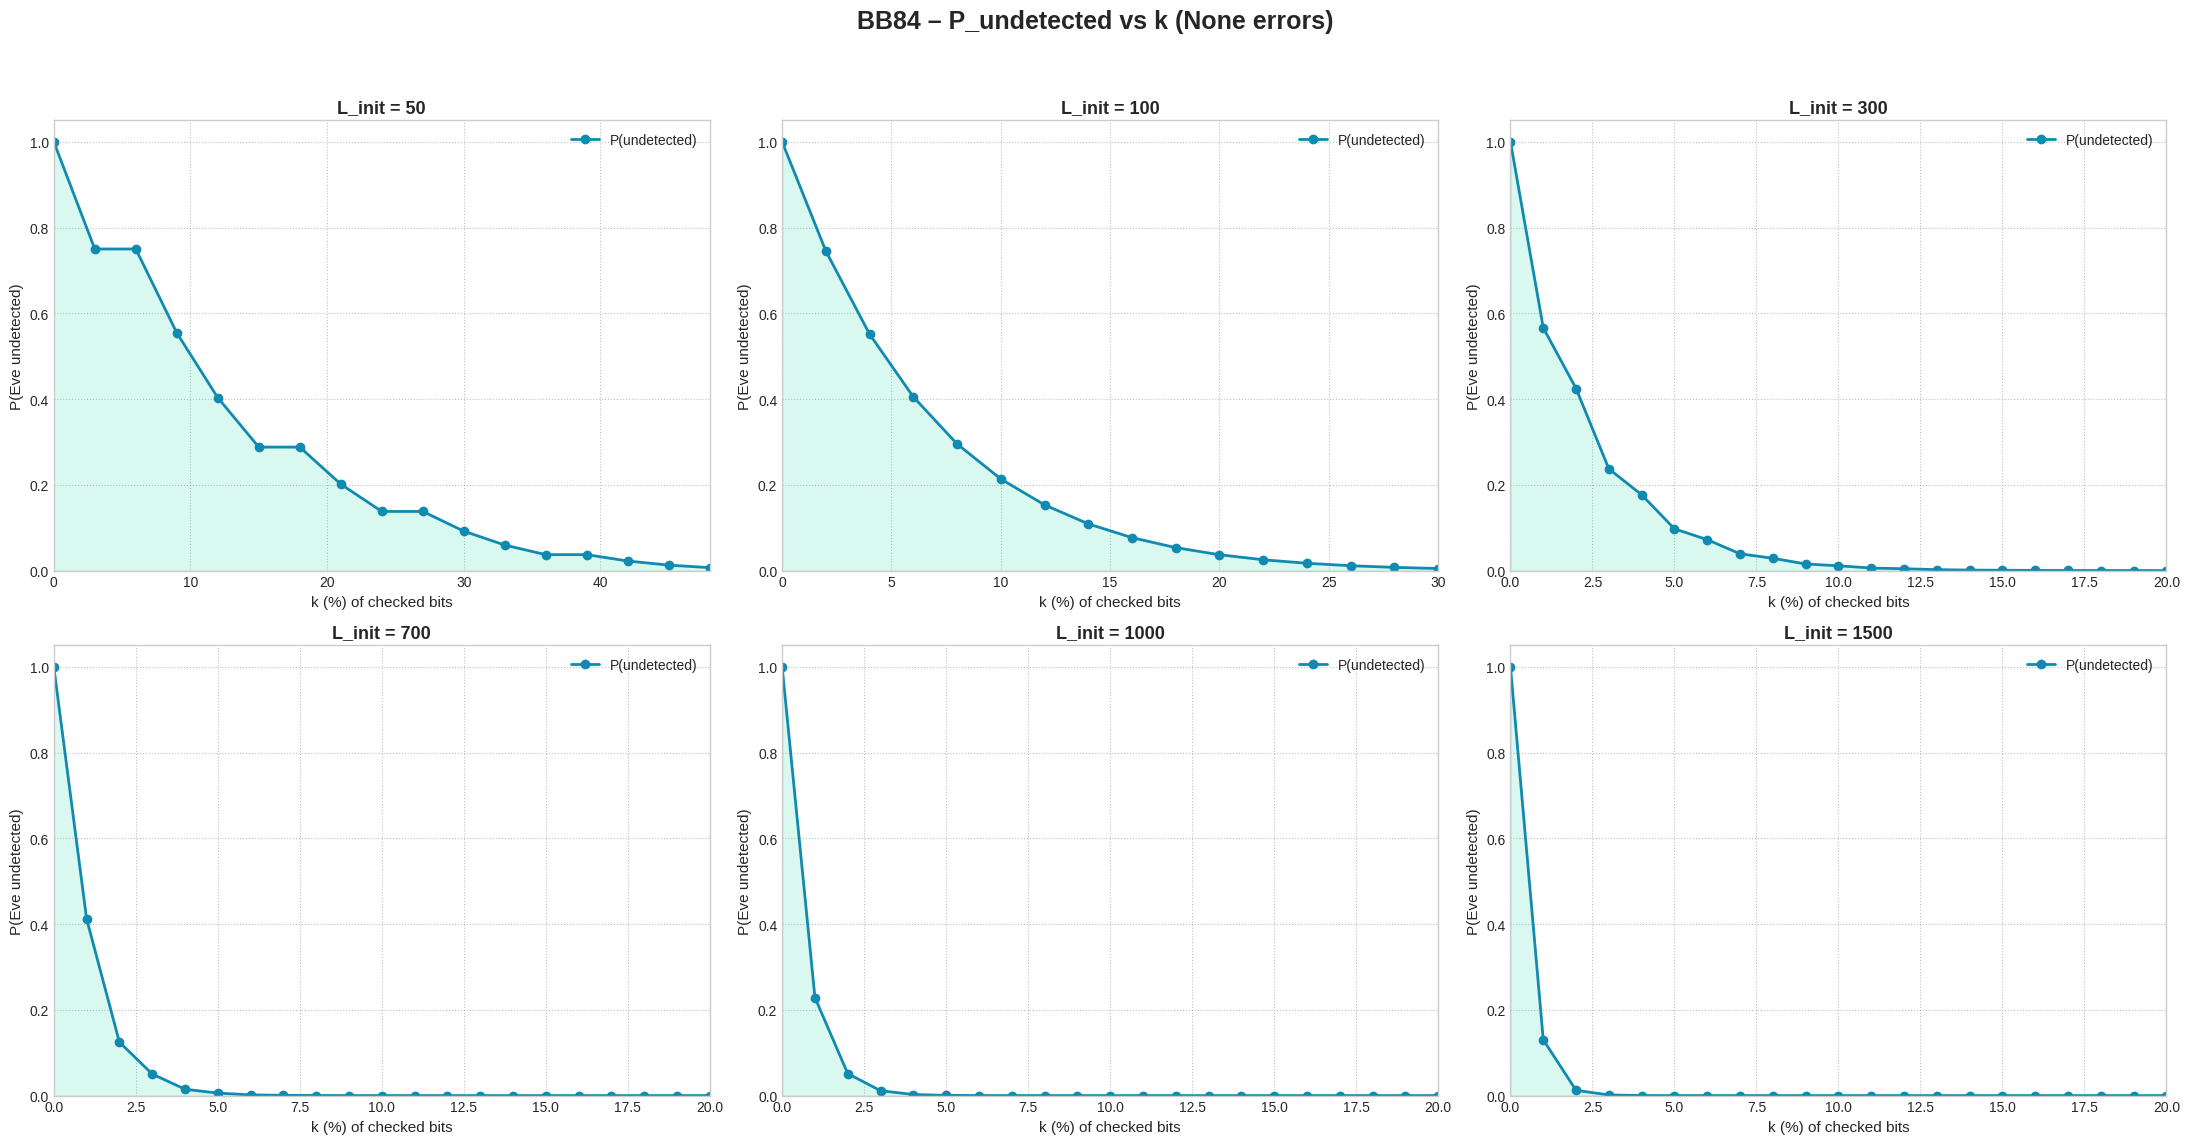

In [ ]:
plot_all_p_undetected_curves(qc, noise_type=None, p=0, n_repeats=30, with_eve=True)

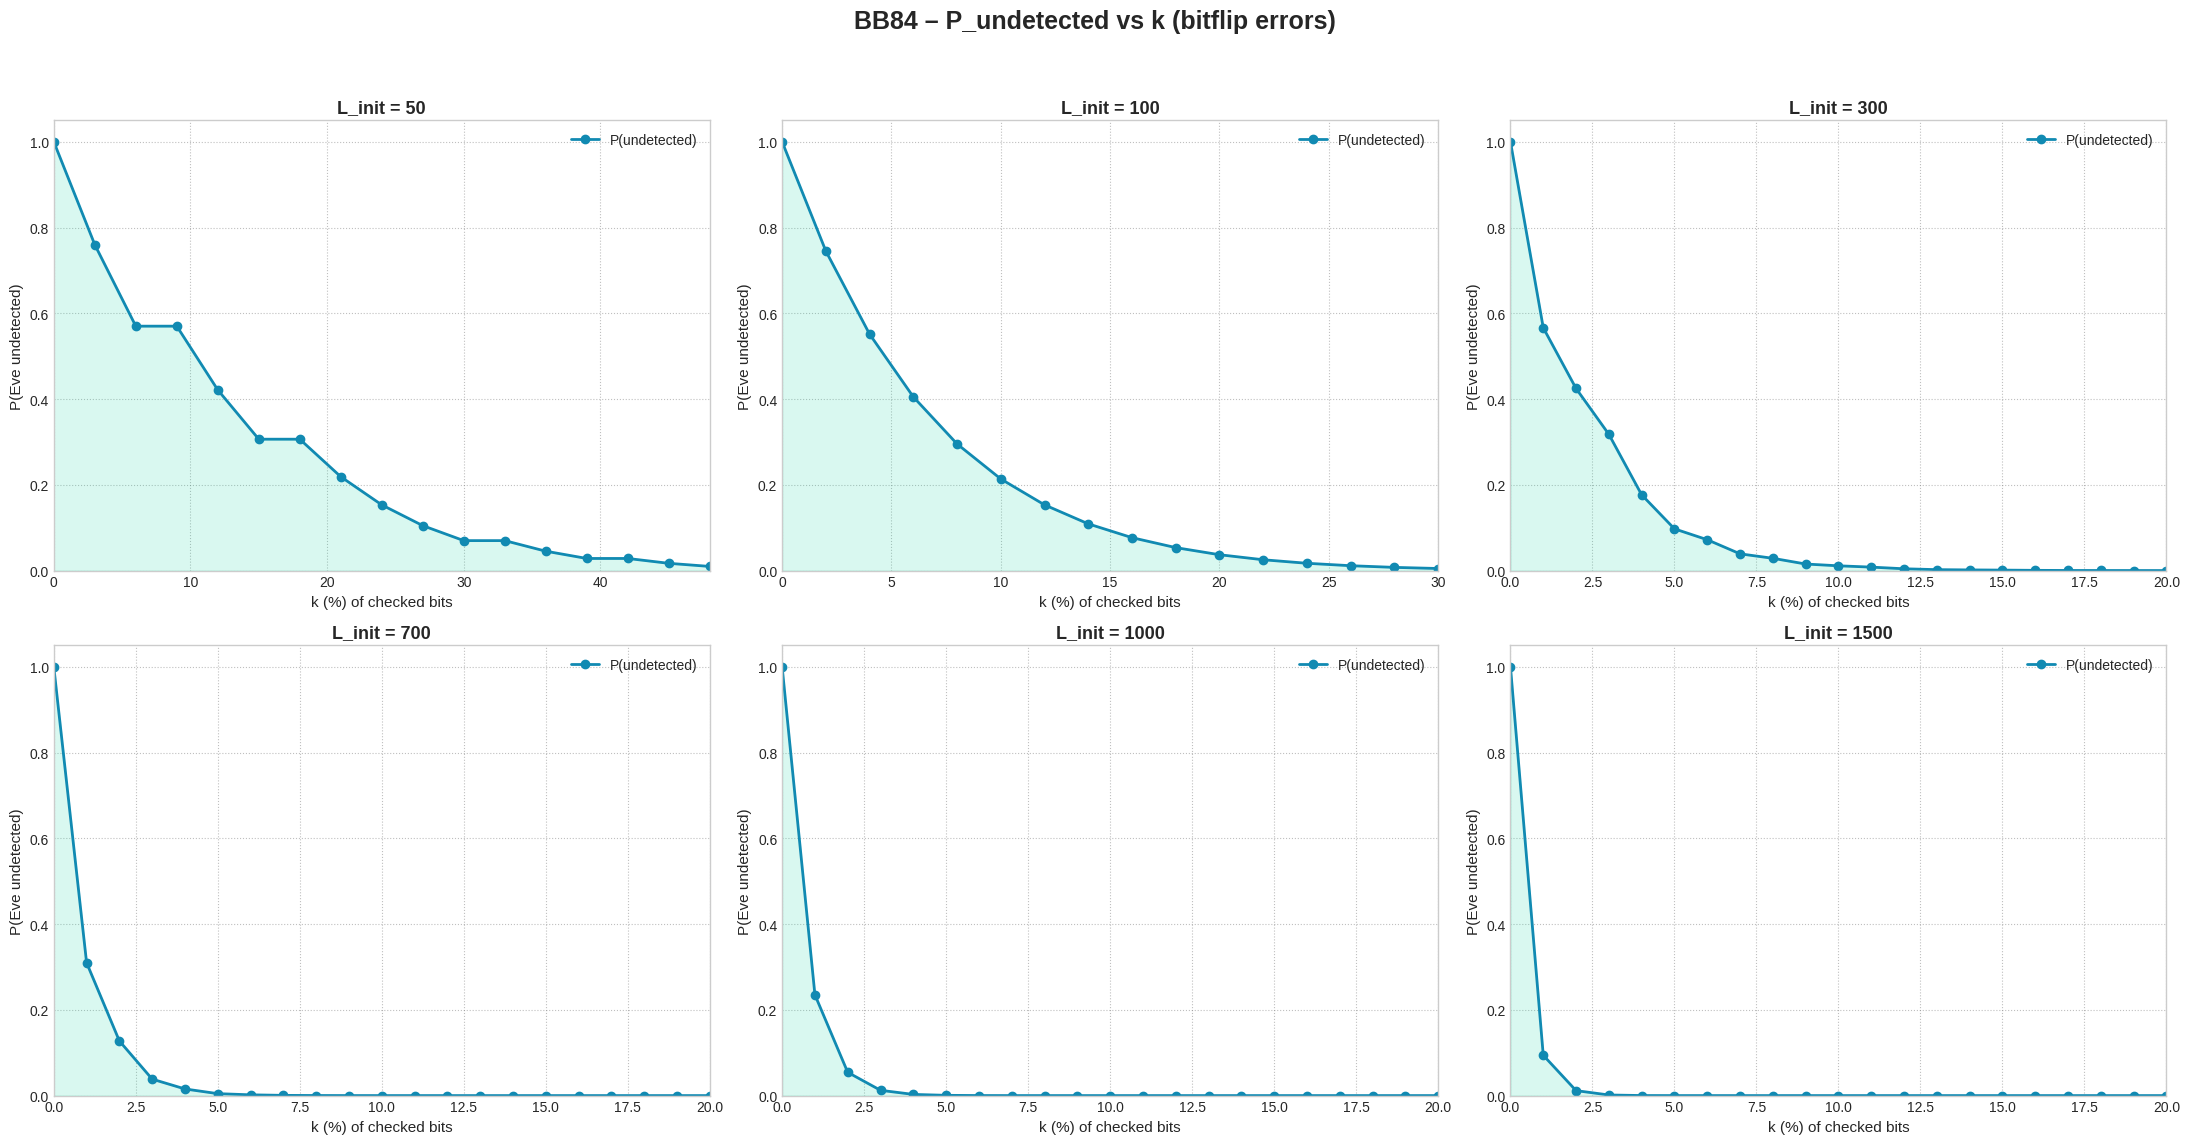

In [ ]:
plot_all_p_undetected_curves(qc, noise_type="bitflip", p=0, n_repeats=30, with_eve=True)

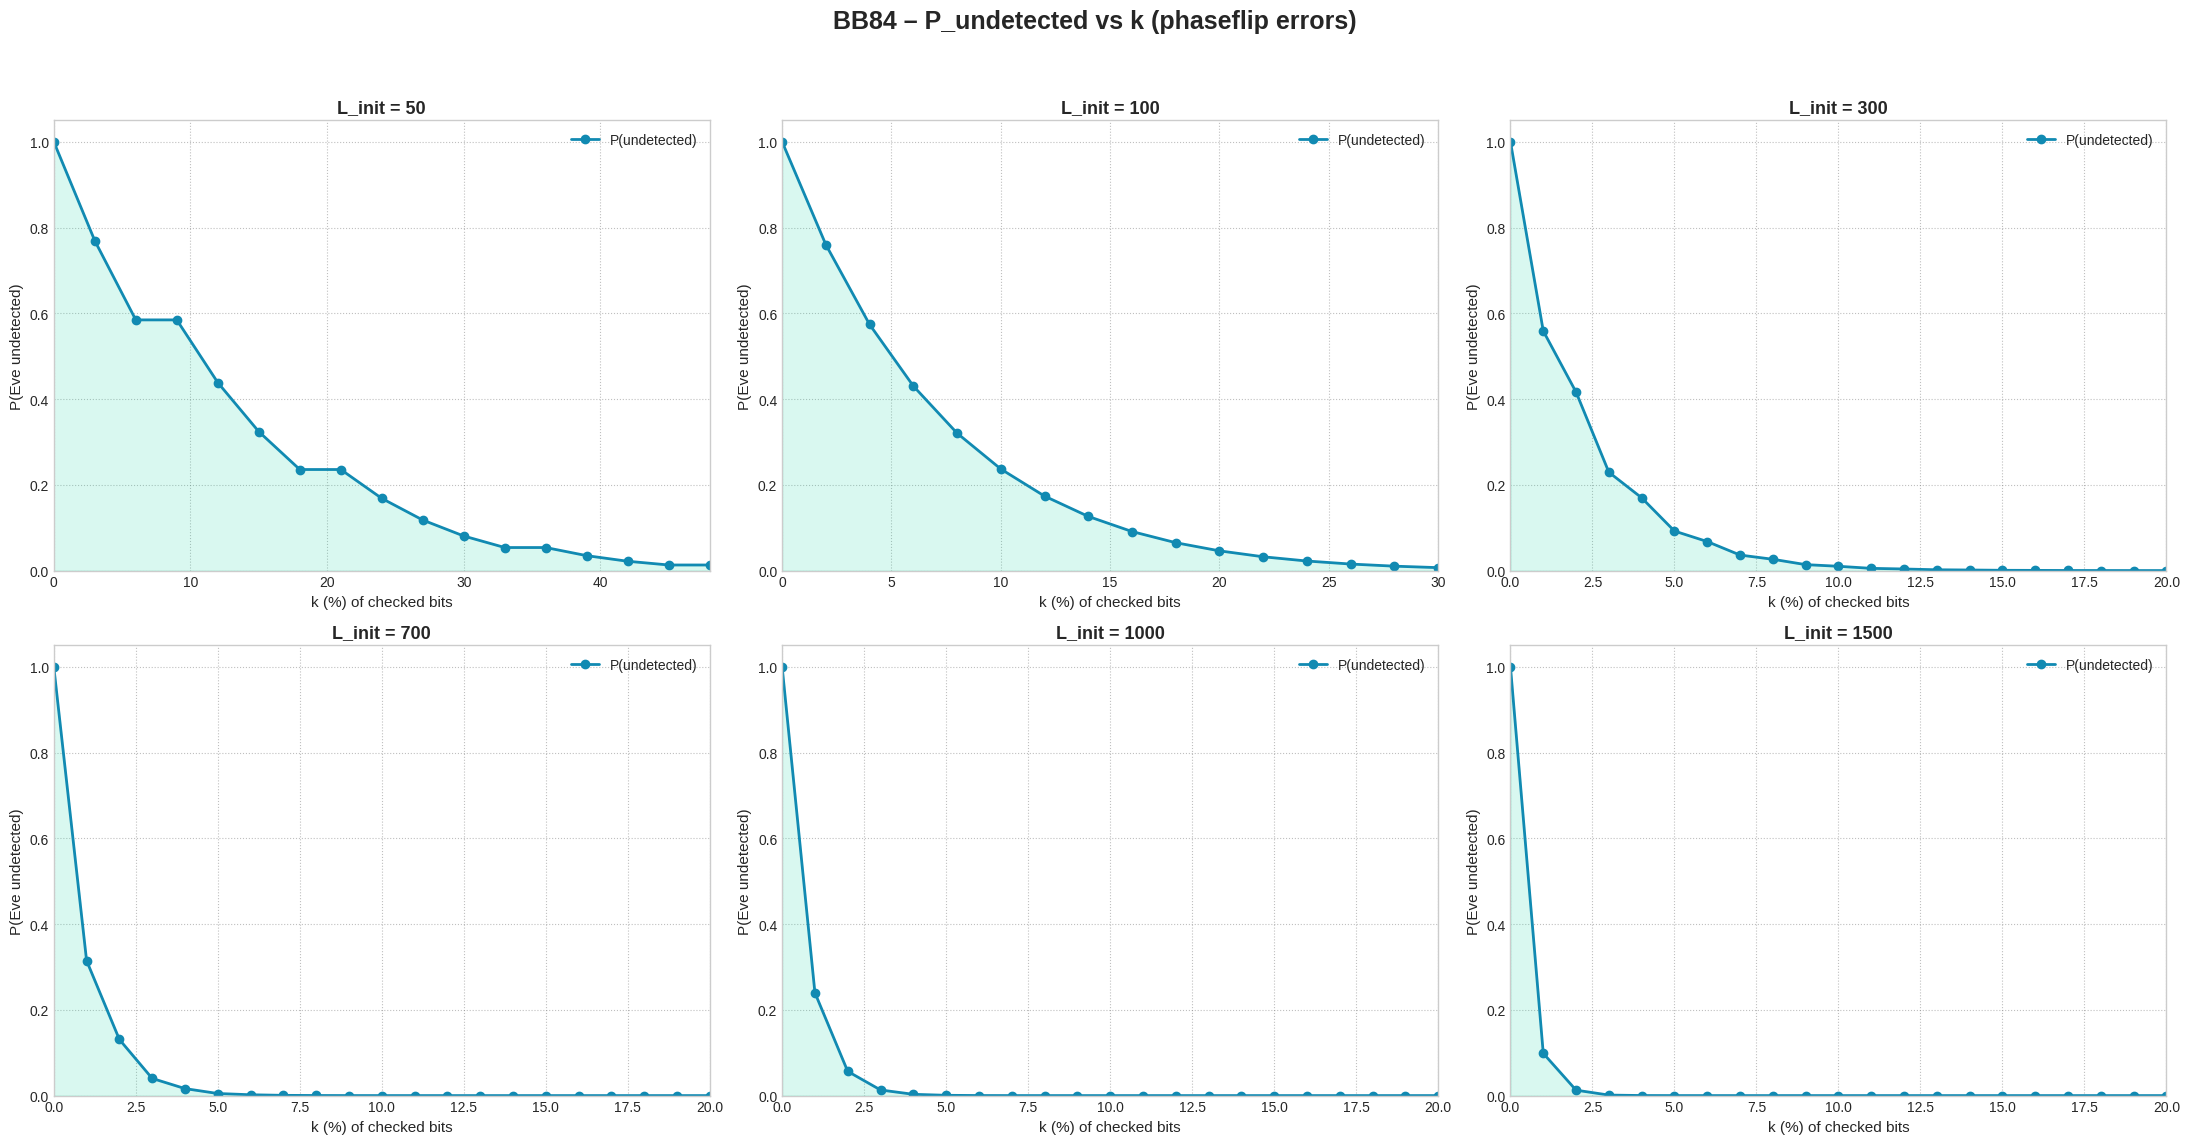

In [ ]:
plot_all_p_undetected_curves(qc, noise_type="phaseflip", p=0, n_repeats=30, with_eve=True)

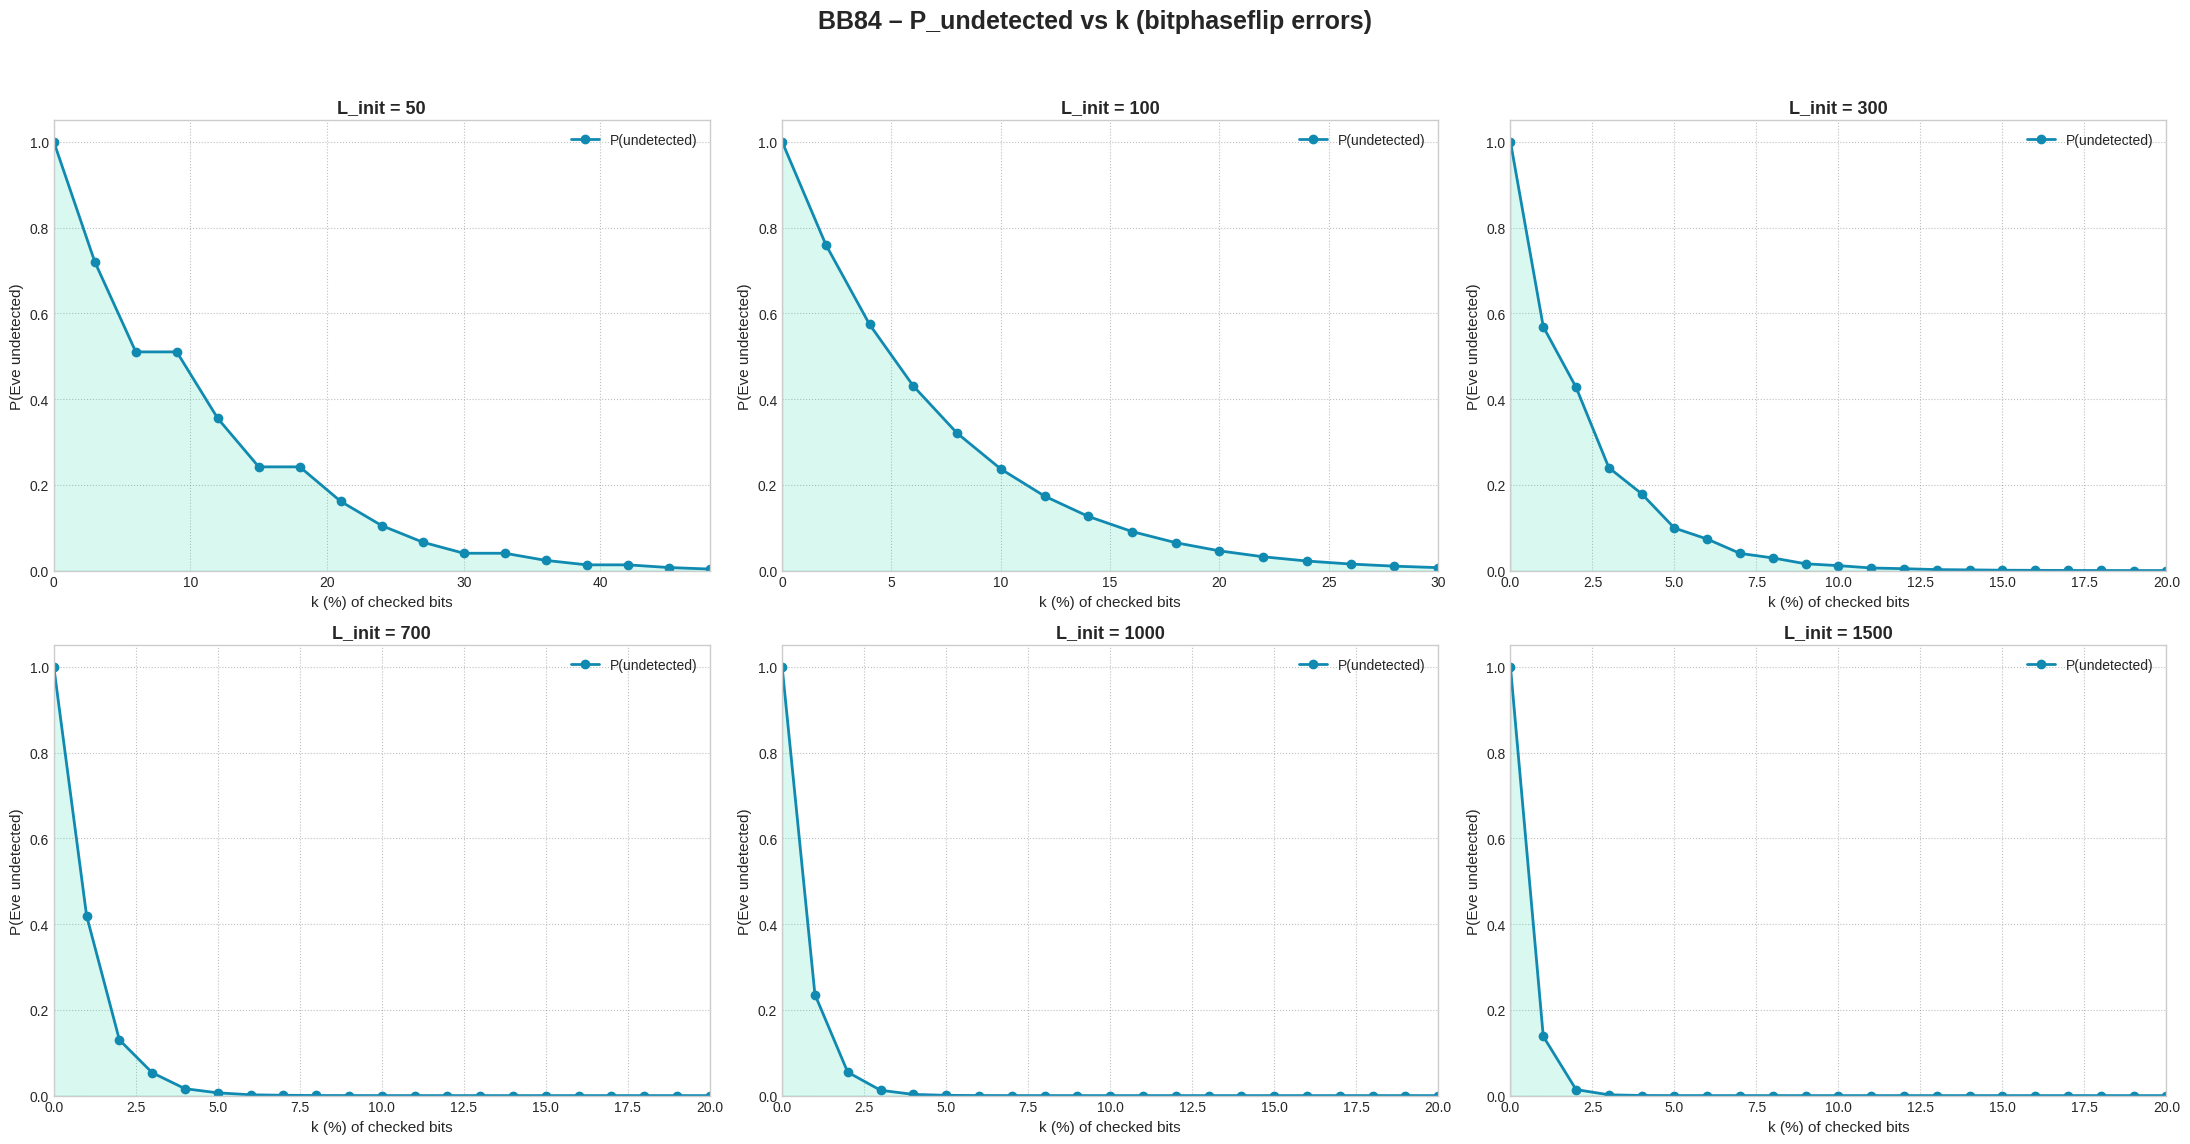

In [ ]:
plot_all_p_undetected_curves(qc, noise_type="bitphaseflip", p=0, n_repeats=30, with_eve=True)